In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import re
from collections import Counter
warnings.filterwarnings('ignore')

### 1. 필요없는 열 제거

In [2]:
df = pd.read_csv("./서울특별시 일반음식점 인허가 정보.csv", encoding='cp949')
print(df.columns)

Index(['개방자치단체코드', '관리번호', '인허가일자', '인허가취소일자', '영업상태코드', '영업상태명', '상세영업상태코드',
       '상세영업상태명', '폐업일자', '휴업시작일자', '휴업종료일자', '재개업일자', '전화번호', '소재지면적',
       '소재지우편번호', '지번주소', '도로명주소', '도로명우편번호', '사업장명', '최종수정일자', '데이터갱신구분',
       '데이터갱신일자', '업태구분명', '좌표정보(X)', '좌표정보(Y)', '위생업태명', '남성종사자수', '여성종사자수',
       '영업장주변구분명', '등급구분명', '급수시설구분명', '총인원', '본사종업원수', '공장사무직종업원수',
       '공장판매직종업원수', '공장생산직종업원수', '건물소유구분명', '보증액', '월세액', '다중이용업소여부', '시설총규모',
       '전통업소지정번호', '전통업소주된음식', '홈페이지'],
      dtype='object')


In [3]:
df = df[['상세영업상태코드', '도로명주소' , '사업장명', '업태구분명', '좌표정보(X)', '좌표정보(Y)']]
df.head()

,상세영업상태코드,도로명주소,사업장명,업태구분명,좌표정보(X),좌표정보(Y)
0,1,NaN,일식동경,일식,NaN,NaN
1,1,서울특별시 종로구 삼일대로 382 (관철동),상해,분식,198867.702591,451824.281126
2,1,서울특별시 관악구 신림로59길 15-13 4층 (신림동),미쿠,일식,193687.348199,442284.164025
3,1,서울특별시 구로구 구로동로22길 21 1층 (구로동),여름엔빙수겨울엔떡국,한식,189814.305919,443046.239859
4,1,서울특별시 강남구 삼성로85길 33 1층 102-2호 (대치동),카페디퍼,기타,204776.548264,444677.642985


### 2. 결측치 제거

In [4]:
def check_null(df):    
    total_cnt = 0
    for i in df.columns:
        cnt = sum(df[i].isnull())
        total_cnt += cnt
        if cnt:
            print(f'{i}열에 결측치{cnt}개')
        else:
            print(f'{i}열에 결측치 없음')
    if total_cnt == 0:
        print('모든 열에 결측치 없음')
    else:
        print(f'총 결측치 {total_cnt}개')

In [5]:
check_null(df)

상세영업상태코드열에 결측치 없음
도로명주소열에 결측치250895개
사업장명열에 결측치1개
업태구분명열에 결측치21개
좌표정보(X)열에 결측치24965개
좌표정보(Y)열에 결측치24965개
총 결측치 300847개


In [6]:
df = df.dropna()
df.head()

,상세영업상태코드,도로명주소,사업장명,업태구분명,좌표정보(X),좌표정보(Y)
1,1,서울특별시 종로구 삼일대로 382 (관철동),상해,분식,198867.702591,451824.281126
2,1,서울특별시 관악구 신림로59길 15-13 4층 (신림동),미쿠,일식,193687.348199,442284.164025
3,1,서울특별시 구로구 구로동로22길 21 1층 (구로동),여름엔빙수겨울엔떡국,한식,189814.305919,443046.239859
4,1,서울특별시 강남구 삼성로85길 33 1층 102-2호 (대치동),카페디퍼,기타,204776.548264,444677.642985
5,1,서울특별시 동대문구 난계로30길 28-7 1층 (신설동),메이크데이(MakeDay),기타,202114.228397,452392.093759


### 3. 폐업 음식점 제거

In [7]:
df["상세영업상태코드"].value_counts().sort_index()

1    121762
2    101045
Name: 상세영업상태코드, dtype: int64

In [8]:
df = df[df["상세영업상태코드"] == 1]

In [9]:
df["상세영업상태코드"].value_counts().sort_index()
df = df.drop(columns='상세영업상태코드')
df.head()

,도로명주소,사업장명,업태구분명,좌표정보(X),좌표정보(Y)
1,서울특별시 종로구 삼일대로 382 (관철동),상해,분식,198867.702591,451824.281126
2,서울특별시 관악구 신림로59길 15-13 4층 (신림동),미쿠,일식,193687.348199,442284.164025
3,서울특별시 구로구 구로동로22길 21 1층 (구로동),여름엔빙수겨울엔떡국,한식,189814.305919,443046.239859
4,서울특별시 강남구 삼성로85길 33 1층 102-2호 (대치동),카페디퍼,기타,204776.548264,444677.642985
5,서울특별시 동대문구 난계로30길 28-7 1층 (신설동),메이크데이(MakeDay),기타,202114.228397,452392.093759


### 4. 업종구분 재분류

In [10]:
df["업태구분명"].value_counts().sort_index()

감성주점                223
경양식                9228
기타                17812
김밥(도시락)             583
까페                 2092
냉면집                 103
라이브카페               190
복어취급                 51
분식                 9048
뷔페식                 457
식육(숯불구이)            882
외국음식전문점(인도태국등)     1370
이동조리                  7
일식                 6118
전통찻집                 51
정종/대포집/소주방         2229
중국식                4531
출장조리                100
커피숍                   3
키즈카페                 66
탕류(보신용)             143
통닭(치킨)             2530
패밀리레스트랑             171
패스트푸드               705
한식                52145
호프/통닭             10353
회집                  276
횟집                  295
Name: 업태구분명, dtype: int64

In [11]:
a = [['경양식','뷔페식','패밀리레스트랑'], #양식
     ['회집','횟집','복어취급'], #해산물
     ['분식','냉면집','김밥(도시락)'], #분식
     ['통닭(치킨)','호프/통닭'], #치킨
     ['한식','탕류(보신용)'], #한식
     ['커피숍','까페','키즈카페','라이브카페','전통찻집','기타'], #카페
     ['정종/대포집/소주방','감성주점'], #술집
     ['식육(숯불구이)'], #고기
     ['중국식'], #중식
     ['외국음식전문점(인도태국등)'], #외국음식
     ['출장조리','이동조리']] #error
# 일식, 패스트푸드 그대로 사용

b = ['양식','해산물','분식','치킨','한식','카페','술집','고기','중식','외국음식','error']

food_list = df["업태구분명"].to_list()
for i,j in enumerate(food_list):
    for x,y in enumerate(a):
        if j in y:
            food_list[i] = b[x]
            
df.insert(3,'업종',food_list)
df = df.drop(columns='업태구분명')
df = df[df['업종'] != 'error']
df.head()

,도로명주소,사업장명,업종,좌표정보(X),좌표정보(Y)
1,서울특별시 종로구 삼일대로 382 (관철동),상해,분식,198867.702591,451824.281126
2,서울특별시 관악구 신림로59길 15-13 4층 (신림동),미쿠,일식,193687.348199,442284.164025
3,서울특별시 구로구 구로동로22길 21 1층 (구로동),여름엔빙수겨울엔떡국,한식,189814.305919,443046.239859
4,서울특별시 강남구 삼성로85길 33 1층 102-2호 (대치동),카페디퍼,카페,204776.548264,444677.642985
5,서울특별시 동대문구 난계로30길 28-7 1층 (신설동),메이크데이(MakeDay),카페,202114.228397,452392.093759


### 5. 도로명주소에서 자치구, 자치동 분류

In [12]:
address_list = df['도로명주소'].to_list()
address_list

['서울특별시 종로구 삼일대로 382 (관철동)',
 '서울특별시 관악구 신림로59길 15-13 4층 (신림동)',
 '서울특별시 구로구 구로동로22길 21 1층 (구로동)',
 '서울특별시 강남구 삼성로85길 33 1층 102-2호 (대치동)',
 '서울특별시 동대문구 난계로30길 28-7 1층 (신설동)',
 '서울특별시 은평구 응암로21가길 9-11 1층 102호 (응암동)',
 '서울특별시 강남구 논현로150길 13 혜창빌딩 지상1층 (논현동)',
 '서울특별시 강북구 수유로12길 60 1층 (수유동)',
 '서울특별시 영등포구 의사당대로1길 25 하남빌딩 2층 202호 203(일부)호 (여의도동)',
 '서울특별시 강남구 테헤란로52길 21 역삼동 벤처빌딩 지하1층 4호 (역삼동)',
 '서울특별시 관악구 신림로22길 5 대학당 지하1층 (신림동)',
 '서울특별시 중랑구 봉우재로 155 1층 105호 (상봉동)',
 '서울특별시 서초구 강남대로99길 35 1층 102호 (잠원동)',
 '서울특별시 강서구 곰달래로 93 1층 (화곡동)',
 '서울특별시 영등포구 선유로47길 15 구산드림타워 1층 108-1호 (양평동4가)',
 '서울특별시 강동구 구천면로47길 20 1층 (암사동)',
 '서울특별시 종로구 창신길 78 1층 (창신동)',
 '서울특별시 성동구 아차산로1길 12 1층 (성수동1가)',
 '서울특별시 관악구 보라매로3길 10 1층 (봉천동)',
 '서울특별시 노원구 공릉로46길 32 상가동 1층 110-1호 (공릉동 삼익아파트)',
 '서울특별시 서초구 강남대로97길 23 1층 (잠원동)',
 '서울특별시 서초구 강남대로105길 5 12층 (잠원동)',
 '서울특별시 구로구 서해안로 2102 솔보프라자 1층 103 105호 (항동)',
 '서울특별시 강동구 강동대로53길 93 1층 101102호 (성내동)',
 '서울특별시 중구 필동로 24-5 1~2층 (필동2가)',
 '서울특별시 성북구 종암로25길 22-29 1층 (종암동)',
 '

In [13]:
gu_list = [address_list[i].split()[1] for i in range(len(address_list))]
gu_list

['종로구',
 '관악구',
 '구로구',
 '강남구',
 '동대문구',
 '은평구',
 '강남구',
 '강북구',
 '영등포구',
 '강남구',
 '관악구',
 '중랑구',
 '서초구',
 '강서구',
 '영등포구',
 '강동구',
 '종로구',
 '성동구',
 '관악구',
 '노원구',
 '서초구',
 '서초구',
 '구로구',
 '강동구',
 '중구',
 '성북구',
 '중구',
 '구로구',
 '관악구',
 '강남구',
 '도봉구',
 '용산구',
 '강북구',
 '구로구',
 '강남구',
 '광진구',
 '송파구',
 '강동구',
 '마포구',
 '강서구',
 '서초구',
 '강서구',
 '영등포구',
 '관악구',
 '강동구',
 '강서구',
 '마포구',
 '마포구',
 '송파구',
 '송파구',
 '중구',
 '은평구',
 '관악구',
 '강남구',
 '관악구',
 '금천구',
 '마포구',
 '관악구',
 '성동구',
 '동대문구',
 '마포구',
 '은평구',
 '마포구',
 '마포구',
 '중랑구',
 '마포구',
 '송파구',
 '서초구',
 '노원구',
 '마포구',
 '용산구',
 '종로구',
 '서초구',
 '서초구',
 '강북구',
 '광진구',
 '서초구',
 '서초구',
 '마포구',
 '송파구',
 '마포구',
 '송파구',
 '송파구',
 '노원구',
 '동작구',
 '서초구',
 '서초구',
 '송파구',
 '서초구',
 '강남구',
 '서초구',
 '광진구',
 '서초구',
 '서초구',
 '서초구',
 '은평구',
 '성북구',
 '구로구',
 '강남구',
 '서초구',
 '서초구',
 '도봉구',
 '서초구',
 '서초구',
 '강동구',
 '동작구',
 '강동구',
 '구로구',
 '서초구',
 '서초구',
 '서초구',
 '서초구',
 '강남구',
 '강남구',
 '용산구',
 '강남구',
 '송파구',
 '광진구',
 '광진구',
 '마포구',
 '용산구',
 '송파구',
 '송파구',
 '강남구',
 '관악구'

In [14]:
dong_list = []
for i in range(len(address_list)):
    try:
        dong_list.append(re.findall('\(.+동',address_list[i])[0].split()[0][1:].split('(')[0]) #정규표현식
    except:
        dong_list.append('error')

In [15]:
for i in dong_list:
    print(i)

관철동
신림동
구로동
대치동
신설동
응암동
논현동
수유동
일부)호
역삼동
신림동
상봉동
잠원동
화곡동
양평동
암사동
창신동
성수동
봉천동
공릉동
잠원동
잠원동
항동
성내동
필동
종암동
error
구로동
봉천동
율현동
창동
서계동
우이동
구로동
도곡동
화양동
송파동
상일동
당인동
마곡동
서초동
마곡동
영등포동
봉천동
천호동
마곡동
연남동
연남동
신천동
잠실동
error
신사동
봉천동
신사동
봉천동
가산동
공덕동
봉천동
금호동
제기동
상수동
진관동
서교동
서교동
중화동
연남동
문정동
서초동
상계동
염리동
한남동
삼청동
양재동
양재동
미아동
군자동
서초동
반포동
상수동
문정동
서교동
잠실동
삼전동
상계동
사당동
양재동
서초동
삼전동
서초동
역삼동
서초동
구의동
양재동
서초동
서초동
구산동
동선동
구로동
신사동
서초동
서초동
창동
서초동
서초동
성내동
사당동
상일동
가리봉동
서초동
서초동
서초동
서초동
청담동
역삼동
한남동
자곡동
잠실동
중곡동
광장동
창전동
보광동
삼전동
석촌동
신사동
봉천동
대림동
용답동
신천동
용두동
독산동
하월곡동
창동
창동
흥인동
성수동
응암동
논현동
망원동
방이동
석촌동
시흥동
당산동
신정동
가양동
성수동
목동
역삼동
성북동
논현동
화곡동
공릉동
암사동
신사동
가산동
북아현동
error
면목동
서교동
삼전동
방배동
신림동
번동
도곡동
잠원동
망원동
오류동
서교동
서초동
마천동
성내동
신림동
하왕십리동
양평동
쌍문동
망우동
서초동
성산동
성내동
성산동
봉천동
독산동
영등포동
서교동
잠원동
묵동
잠원동
잠원동
서초동
잠원동
신내동
구로동
구로동
잠원동
면목동
상계동
수유동
논현동
등촌동
천호동
서초동
염리동
서초동
면목동
삼성동
서초동
서초동동
응암동
잠원동
양평동
사당동
서초동
서초동
창천동
서초동
잠원동
잠원동
시흥동지상1층
잠원동
논현동
봉천동
당산동
잠원동
서초동
서초동
이태원동
이태원동
잠원동
잠원동
잠원동
서초동
미아동
천호동
당산동
잠원동
잠원동
서초동
서초동
서초동
서초동
서초동
상봉동
서초동
서초동
잠원동
잠원동
서초동
서초동


창신동
묘동
관훈동
답십리동
창신동
error
관철동
이화동
제기동
수송동
error
error
관철동
효자동
창신동
동숭동
내자동
동숭동
부암동
창신동
숭인동
당주동
관철동
묘동
관철동
명륜2가
등촌동
error
적선동
숭인동
권농동
인의동
관훈동
익선동
관철동
안국동
마곡동
관철동
동숭동
장사동
혜화동
장사동
효제동
청진동
error
이화동
돈의동
혜화동
혜화동
통의동
묘동
관철동
관훈동
청진동
창신동
이화동
당주동
관철동
부암동
창신동
창신동
숭인동
숭인동
수송동
평창동
효자동
체부동
청진동
역촌동
숭인동
익선동
error
이화동
논현동
평동
숭인동
연지동
통의동
구기동
error
누하동
error
운니동
당주동
error
경운동
error
관철동
도렴동
적선동
내수동
익선동
error
신정동
내자동
청진동
error
청진동
관철동
통인동
관철동
청진동
관수동
재동
신영동
옥인동
화동
도렴동
동숭동
권농동
중곡동
error
체부동
체부동
삼청동
삼청동
error
구의동
내자동
숭인동
error
관훈동
재동
관철동
관철동
적선동
당주동
안국동
숭인동
당주동
당주동
당주동
error
자양동
견지동
동숭동
행촌동
청진동
동숭동
수송동
삼선동
관철동
내수동
낙원동
원남동
필운동
당주동
당주동
삼청동
error
양재동
부암동
소격동
소격동
동숭동
송월동
관수동
창신동
사직동
익선동
error
안국동
효제동
숭인동
error
낙원동
익선동
낙원동
소격동
소격동
error
내수동
error
error
error
error
error
error
error
error
error
청진동
합정동
필운동
error
창신동
가회동
팔판동
연건동
내수동
error
동숭동
서교동
청진동
내자동
낙원동
평동
익선동
error
삼청동
수송동
연지동
수송동
궁정동
삼청동
창신동
노고산동
삼청동
화곡동
신사동
error
관철동
인의동
이화동
명륜3가
동숭동
삼청동
구기동
천호동
error
낙원동
error
소격동
숭인동
error
낙원동
충신동
창신동
통의동
error
관철동
error


관훈동
구기동
관훈동
창신동
청진동
동숭동
error
내수동
팔판동
숭인동
error
통의동
관철동
역삼동
관훈동
통의동
error
창신동
관수동
방화동
인사동
원남동
가회동
창신동
인의동
돈의동
돈의동
관훈동
행촌동
팔판동
이태원동
돈의동
인의동
사간동
관철동
error
체부동
체부동
창신동
무악동
error
숭인동
역삼동
익선동
낙원동
관철동
도화동
누하동
역삼동
수송동
돈의동
error
관철동
삼청동
error
중학동
도렴동
관철동
누하동
당주동
홍지동
error
원남동
홍지동
충신동
적선동
당주동
충신동
관철동
숭인동
error
동숭동
재동
안국동
신정동
error
관훈동
창신동
적선동
효제동
내수동
체부동
청진동
역삼동
error
수송동
돈의동
청진동
운니동
동선동
창신동
필운동
평동
필운동
숭인동
당주동
숭인동
낙원동
숭인동
구기동동
내자동
창신동
숭인동
인의동
error
error
error
체부동
숭인동
인사동
동숭동
재동
도렴동
권농동
error
낙원동
삼청동
부암동
역삼동
error
error
필운동
error
창신동
무악동
동숭동
평창동
부암동
동숭동
봉익동
권농동
내수동
창신동
평창동
도렴동
체부동
error
error
도렴동
관훈동
창성동
삼청동
숭인동
운니동
삼성동
역삼동
행촌동
불광동
인의동
필운동
내수동
error
error
error
삼성동
효자동
청진동
숭인동
익선동
사간동
휘경동
옥인동
신월동
error
숭인동
error
독산동
창신동
통인동
error
이화동
수송동
돈의동
error
error
연지동
error
통의동
통의동
창신동
구기동
무악동
평창동
숭인동
error
error
평창동
낙원동
부암동
error
역삼동
error
동숭동
제기동
팔판동
구기동
창신동
error
error
충신동
내자동
당주동
관수동
동숭동
삼청동
서린동
낙원동
돈의동
관철동
구기동
error
화동
내자동
홍지동
관훈동
관철동
이화동
관철동
관훈동
당주동
당주동
연건동
error
청운동
동숭동
연건동
창신동
연건동
낙원동
동숭동
숭인동
교남동


남산동
무교동
신당동
error
황학동
장충동
신당동
봉래동
신당동
신당동
서소문동
명동
순화동
황학동
흥인동
error
error
서소문동
error
error
장교동
황학동
남창동
error
서소문동
error
순화동
신당동
신당동
황학동
남산동
신당동
필동
회현동
예관동
서소문동
서소문동
황학동
error
장충동
봉래동
error
중림동
연희동
필동
수표동
error
신당동
신당동
신당동
수표동
내수동
황학동
신당동
신당동
북창동
필동
장안동
error
수하동
명동
황학동
창천동
error
필동
필동
회현동
신당동
북창동
등촌동
error
신당동
황학동
error
저동
신당동
error
error
error
황학동
정동
무학동
남가좌동
초동
남창동
소공동
서소문동
중림동
error
수표동
신당동
신당동
장충동
황학동
명동
남창동
필동
error
error
신당동
error
error
명동
화곡동
홍제동
등촌동
소공동
다동
다동
필동
필동
회현동
무교동
신당동
흥인동
신당동
남창동
신당동
error
남창동
명동
필동
봉천동
소공동
신당동
명동
도화동
신당동
신당동
필동
초동
다동
광희동
황학동
북창동
중림동
서소문동
신당동
미아동
을지로6가A동
명동
중림동
신당동
error
신당동
error
필동
인현동
중림동
서초동
인현동
회현동
error
회현동
장충동
산림동
필동
error
필동
error
error
신당동
주교동
중림동
error
대방동
error
수표동
저동
회현동
error
명동
입정동
장충동
신당동
당산동
초동
남창동
error
error
error
error
무학동
신당동
필동
error
무학동
을지로7가
자양동
error
error
서초동
error
중림동
광희동
황학동
중림동
무교동
입정동
error
신당동
남창동
저동
중림동
능동
error
신당동
error
신당동
장충동
북창동
신당동
서소문동
신당동
회현동
신당동
북창동
신당동
남산동
필동
회현동
초동
무교동
필동
신당동
신당동
수하동
초동
예관동
구의동
주교동
신당동
error
남창

남영동
이태원동
이태원동
이태원동
서빙고동
error
논현동
동자동
용산동
error
효창동
error
한남동
이태원동
이태원동
이태원동
error
이촌동
장지동
이태원동
갈월동
이태원동
동자동
동자동
서계동
이태원동
용산동
역삼동
error
갈월동
이태원동
error
이태원동
이태원동
용산동
고척동
이태원동
한남동
용문동
갈월동
의류상가)
error
이태원동
용산동
용산동
신계동
동자동
용산동
error
한남동
이태원동
상암동
보광동
error
이태원동
error
용산동
용산동
남영동
error
한남동
error
한남동
이촌동
error
이태원동
이촌동
길동
창전동
서계동
error
동자동
한남동
오류동
error
한남동
서계동
한남동
error
error
error
error
error
error
이태원동
한남동
한남동
이태원동
한남동
서계동
error
이태원동
천호동
error
error
한남동
이촌동
이촌동
error
이태원동
후암동
이태원동
이촌동
error
한남동
보광동
이태원동
이촌동
이태원동
이태원동
이태원동
신림동
동빙고동
후암동
용산동
보광동
error
청파동
이태원동
error
용산동
동자동
error
신림동
error
당산동
동자동
동자동
한남동
이태원동
동자동
동자동
남영동
동자동
보광동
서빙고동
error
용산동
이태원동
동자동
보광동
보광동
보광동
이태원동
용강동
용산동
error
error
error
error
error
error
error
이태원동
이태원동
삼전동
한남동
한남동
망원동
서계동
error
청파동
이촌동현대상가
보광동
이태원동
이태원동
이태원동
error
이태원동
남영동
error
용산동
error
후암동
error
한남동
error
error
error
error
이촌동
한남동
자양동
이태원동
동자동
error
효창동
용문동
보광동
남영동
동자동
한남동
error
서계동
이태원동
이촌동
error
이태원동
이태원동
동빙고동
서계동
한남동
이태원동
후암동
이태원동
이촌동
후암동
error
천호동
한남동
한남동
이태원

error
이태원동
보광동
한남동
error
error
이태원동
갈월동
동자동
error
갈월동
error
이태원동
화양동
청파동
이촌동
error
이촌동
이태원동
한남동
이태원동
error
한남동
error
한남동
서계동
효창동
한남동
한남동
신월동
error
한남동
한남동
error
error
동빙고동
이태원동
이태원동
이태원동
이태원동
error
error
이태원동
이태원동
신정동
문배동
역삼동
한남동
남영동
청파동
동자동
갈월동
이태원동
보광동
한남동
청파동
error
이촌동
남영동
후암동비동
이태원동
한남동
이태원동
이태원동
후암동
error
이태원동
error
error
error
이태원동
서계동
여의도동
error
한남동
적선동
한남동
이태원동
역삼동
한남동
이태원동
이촌동
한남동
서계동
error
한남동
용산동
error
error
error
error
error
error
용산동
압구정동
효창동
error
error
이촌동
보광동
한남동
청파동
보광동
후암동
서계동
후암동
삼성동
한남동
한남동
역삼동
error
error
후암동
서계동
한남동
이태원동
효창동
이태원동
error
보광동
한남동
동빙고동
동빙고동
용산동
신사동
한남동
이촌동
한남동
한남동
청파동
error
error
error
이태원동
한남동
이태원동
error
이태원동
한남동
용산동
error
상계동
상계동
천호동
상계동
봉래동
월계동
대조동
천호동
error
방이동
구산동
응암동
상도동
하왕십리동
성수동
장안동
금호동
합정동
구로동
대치동
서교동
여의도동
내발산동
여의도동
서교동
삼청동
사직동
상봉동
도선동삼성쉐르빌101동
행당동
행당동
용답동
금호동
행당동
행당동
용답동
행당동
나)호
성수동
행당동
행당동
행당동
교북동
용산동
행당동
성수동
행당동
용답동
하왕십리동
하왕십리동
금호동
성수동
용답동
응봉동
성수동
도선동
하왕십리동
성수동
성수동
error
용답동
행당동
행당동
하왕십리동
하왕십리동
성수동
마장동
성수동
행당동
행당동
용답동
행당동
성수동
금호동
성수동
마장동
도

광장동
광장동
화양동
군자동
자양동
중곡동
암사동
자양동
중곡동
중곡동
구의동
자양동
구의동
중곡동
자양동
구의동
중곡동
군자동
구의동
연남동
자양동
군자동
광장동
불광동
구의동
자양동
자양동
자양동
구의동
화양동
화양동
행당동
자양동
군자동
중곡동
화양동
화양동
회기동
자양동
구의동
능동
구의동
화양동
자양동
화양동
중곡동
구의동
광장동
자양동
화양동
화양동
화양동
자양동
중곡동
자양동
구의동
자양동
중곡동
중곡동
화양동
화양동
중곡동
중곡동
중곡동
망원동
자양동
중곡동
화양동
자양동
자양동
화양동
서교동
화양동
화양동
화양동
중곡동
구의동
자양동
자양동
구의동
자양동
자양동
중곡동
구의동
상암동
자양동
자양동
군자동
화양동
중곡동
중곡동
중곡동
화양동
구의동
화양동
화양동
군자동
화양동
중곡동
양재동
자양동
중곡동
중곡동
청담동
자양동
중곡동
군자동
화양동
화양동
화양동
구의동
광장동
논현동
구의동
화양동
자양동
능동
화양동
구의동
자양동
도곡동
중곡동
중곡동
화양동
중곡동
화양동
화양동
자양동
자양동
청담동
광장동
구의동
구의동
화양동
화양동
중곡동
자양동
화양동
중곡동
논현동
광장동
중곡동
군자동
광장동
자양동
화양동
능동
구의동
중곡동
자양동
자양동
군자동
논현동
군자동
구의동
중곡동
중곡동
중곡동
화양동
자양동
중곡동
수유동
광장동
구의동
자양동
자양동
화양동
능동
중곡동
구의동
자양동
화양동
중곡동
자양동
자양동
중곡동
신길동
화양동
화양동
화양동
화양동
구의동
자양동
역삼동
중곡동
화양동
구의동
화양동
성수동
중곡동
화양동
구의동
화양동
군자동
구의동
자양동
능동
군자동
중곡동
상도동
화양동
자양동
화양동
구의동
구의동
화양동
구의동
군자동
화양동
자양동
군자동
구의동
광장동
개포동
자양동
자양동
중곡동
미아동
구의동
자양동
구의동
군자동
자양동
중곡동
자양동
능동
중곡동
도곡동
자양동
화양동
동소문동5가
자양동
자양동
군자동
중곡동
광장동극동
중곡동
자양동
자양동
광장동
성수동
자양동
시흥동
자양동
중곡동
구의동
청담동
화양동
성수동
구의동
자

중곡동
화양동
구의동
자양동
자양동
화양동
중곡동
중곡동
중곡동
구의동
중곡동
능동
자양동
자양동
자양동
능동
응암동
자양동
자양동
응암동
자양동
중곡동
구의동
중곡동
자양동
중곡동
군자동
중곡동
공릉동
신림동
오장동
error
사당동
구의동
응암동
error
도봉동
청파동
구로동
체부동
돈의동
장위동
창동
쌍문동
한남동
장안동
제기동
장안동
제기동
회기동
장안동
제기동
제기동
신설동
장안동
제기동
장안동
답십리동
장안동
용두동
이문동
휘경동
이문동
전농동
전농동
장안동
이문동
답십리동
장안동
이문동
장안동
청량리동
제기동
장안동
제기동
답십리동
전농동
용두동
전농동
전농동
장안동
청량리동
전농동
회기동
용두동
장안동
용두동
용두동
용두동
청량리동
청량리동
장안동
장안동
회기동
신설동
전농동
답십리동
전농동
전농동
장안동
장안동
휘경동
전농동
이문동
답십리동
장안동
장안동
용두동
장안동
전농동
용두동
제기동
회기동
장안동
휘경동
A)호
제기동
제기동
회기동
제기동
용두동
회기동
전농동
답십리동
회기동
전농동
이문동
휘경동
장안동
청량리동
청량리동
답십리동
장안동
장안동
이문동
답십리동
용두동
답십리동
장안동
제기동
장안동
전농동
휘경동
휘경동
답십리동
용두동
장안동
청량리동
답십리동
용두동
제기동
이문동
휘경동
휘경동
휘경동
제기동
용두동동
휘경동
답십리동
용두동
휘경동
제기동
이문동
답십리동
장안동
답십리동
제기동
제기동
전농동
회기동
이문동
장안동
장안동
장안동
회기동
답십리동
제기동
답십리동
용두동
회기동
용두동
제기동
전농동
용두동
장안동
이문동
휘경동
신설동
장안동
이문동
답십리동
신설동
신설동
전농동
제기동
용두동
신설동
제기동
장안동
장안동
제기동
이문동
신설동
회기동
전농동
삼성동
이문동
신설동
장안동
이문동
제기동
제기동
회기동
장안동
회기동
답십리동
신설동
제기동
장안동
전농동
장안동
청량리동
청량리동
장안동
이문동
신설동
답십리동
답십리동
전농동
용두동
용두동
답십리동
장안동
용두동
청량리동
청량리동
신설동
장안동
회기동
용두동
논현동
답십

전농동
장안동
이문동
용두동
용두동
장안동
청량리동
제기동
회기동
회기동
답십리동
회기동
용두동
제기동
전농동
아현동
장안동
전농동
답십리동
이문동
전농동
청량리동
청량리동
청량리동
전농동
답십리동
전농동
장안동
합정동
제기동
용두동
전농동
용두동
답십리동
장안동
장안동
장안동
청량리동
휘경동
신설동
장안동
회기동
이문동
신설동
휘경동
회기동
회기동
제기동
용두동
이문동
휘경동
제기동
회기동
용두동
용두동동
제기동
답십리동
이문동
전농동
이문동
답십리동
답십리동
장안동
장안동
용두동
용두동
신설동
휘경동
장안동
장안동
신설동
청량리동
연남동
제기동
장안동
용두동
회기동
제기동
청량리동
제기동
제기동
회기동
장안동
서교동
청량리동
이문동
답십리동
용두동
회기동
신설동
휘경동
전농동
장안동
이문동
전농동
장안동
용두동
용두동
용두동
회기동
회기동
전농동
홍제동
장안동
진관동
불광동
이문동
휘경동
답십리동
휘경동
전농동
답십리동
장안동
장안동
휘경동
제기동
이문동
휘경동
답십리동
전농동
답십리동
장안동
용두동
장안동
휘경동
답십리동외2필지
전농동
회기동
용두동
장안동
장안동
회기동
답십리동
장안동
답십리동
회기동
용두동
장안동
회기동
장안동
용두동
논현동
장안동
장안동
답십리동
휘경동
이문동
역삼동
이문동
전농동
장안동
장안동
회기동
장안동
답십리동
신설동
휘경동
청량리동
장안동
휘경동
신설동
제기동
회기동
전농동
회기동
논현동
회기동
청량리동
회기동
용두동
청량리동
장안동
용두동
용두동
용두동
휘경동
전농동
휘경동
전농동
장안동
용두동
답십리동
장안동
용두동
답십리동
회기동
회기동
이문동
휘경동
장안동
청량리동
휘경동
용두동
용두동
답십리동
회기동
역삼동
제기동
용두동
이문동
장안동
전농동
중화동
신내동
망우동
면목동
면목동
망우동
면목동
상봉동
신내동
신사동
중화동
면목동
면목동
면목동
상봉동
망우동
면목동
중화동
면목동
면목동
묵동
면목동
삼성동
신내동동
면목동
묵동
중화동
상봉동
중화동
청담동
상봉동
면목동
상봉동
면목동
신내동
방배동
중화동
면목동
면목동


상봉동
신내동
면목동
묵동
중화동
중화동
상봉동
망우동
신내동
중화동
역삼동
도곡동
망우동
신내동
면목동
면목동
망우동
면목동
면목동
망우동
면목동
면목동
망우동
신사동
중화동
면목동나동
망우동
중화동
논현동
상봉동
중화동
면목동
망우동
상봉동
묵동
묵동
중화동
면목동
묵동
묵동
중화동
상봉동
중화동
역삼동
논현동
묵동
면목동
망우동
면목동
신내동
면목동
면목동
상봉동
면목동
묵동
묵동
면목동
중화동
묵동
중화동
신내동
중화동
면목동
묵동
중화동
상봉동
상봉동
망우동
중화동
면목동
신내동
중화동
중화동
면목동
중화동
묵동
역삼동
신림동
면목동
중화동
면목동
신내동
중화동
서교동
논현동
상수동
수유동
천호동
구의동
자양동
낙원동
동선동
삼선동
가산동
석관동
동소문동
정릉동
석관동
상월곡동
동소문동
종암동
정릉동
삼선동
삼선동
삼선동
안암동
안암동
장위동
구로동
error
안암동
안암동
동선동
장위동
동선동
석관동
하월곡동
제기동
안암동
길음동
삼선동
석관동
길음동
석관동
길음동
종암동
하월곡동
보문동
동소문동
안암동
삼선동
석관동
안암동
석관동
장위동
하월곡동
종암동
동소문동
석관동
종암동
정릉동
정릉동
석관동
여의도동
삼선동
안암동
종암동
길음동
영등포동
석관동
장위동
장위동
안암동
종암동
봉천동
동선동
보문동
삼선동
석관동
장위동
석관동
정릉동
안암동
하월곡동
석관동
안암동
돈암동
안암동
종암동
석관동
종암동
하월곡동
동선동
정릉동
하월곡동
양평동
안암동
정릉동
동선동
석관동
정릉동
돈암동
길음동
성북동
종암동
동선동
보문동
석관동
동소문동
동선동
동소문동
동선동
동선동
정릉동
종암동
동소문동
삼선동
하월곡동
석관동
안암동
석관동
하월곡동
정릉동
상월곡동
삼선동
신길동
석관동
동선동
동선동
장위동
보문동
정릉동
정릉동
성북동
안암동
정릉동
하월곡동
하월곡동
장위동
종암동
하월곡동
삼선동
정릉동
신대방동
석관동
장위동
동소문동
동선동
안암동
안암동
안암동
길음동
안암동
장위동
동소문동
장위동
동소문동
보문동
하월곡동
길음동
동선동
정릉동
하월곡동
종암동
안암동

미아동
미아동
미아동
번동
수유동
우이동
번동
수유동
신월동
수유동
미아동
수유동
수유동
미아동
미아동
미아동
미아동
미아동
번동
수유동
미아동
수유동
수유동
미아동
우이동
용두동
수유동
미아동
미아동
번동
수유동
미아동
번동
수유동
미아동
목동
수유동
수유동
수유동
수유동
신정동
미아동
미아동
수유동
미아동
번동
미아동
미아동
수유동
우이동
번동
수유동
미아동
미아동
수유동
미아동상가동
수유동
수유동
당산동
미아동
수유동
영등포동
미아동
미아동
미아동
번동
수유동
전농동
수유동
당산동
우측)호
번동
수유동
수유동
번동
수유동
미아동
수유동
미아동
수유동
수유동
수유동
미아동
양평동
번동
번동
번동
수유동
수유동
수유동
수유동
수유동
수유동
수유동
묵동
여의도동
서교동
수유동
미아동
수유동
번동
번동
수유동
미아동
수유동
수유동
미아동
미아동
미아동
수유동
수유동
수유동
수유동
수유동
수유동
번동
미아동
수유동
수유동
수유동
미아동
수유동
미아동
미아동
미아동
수유동
수유동
미아동
미아동
미아동
화양동
미아동
수유동
미아동
수유동
수유동
수유동
미아동
수유동
수유동
수유동
미아동
번동
군자동
수유동
미아동
우이동
수유동
미아동
수유동
번동
수유동
수유동
수유동
미아동
수유동
우이동
미아동
수유동
미아동
미아동
장위동
미아동
광장동
미아동
수유동
미아동
미아동
수유동
미아동
미아동
미아동
미아동
수유동
수유동
수유동
번동
수유동
미아동
용산동
이태원동
미아동
수유동
수유동
수유동
수유동
수유동
수유동
미아동
수유동
성수동
미아동
번동
미아동바동
수유동
송파동
수유동
번동
수유동
미아동
수유동
번동
수유동
번동
미아동
수유동
수유동
미아동
미아동
미아동
목동
수유동
미아동
미아동
수유동
목동
번동
수유동
번동
미아동
번동
미아동
수유동
수유동
번동
수유동
미아동
미아동
미아동
미아동
번동
번동
수유동
미아동
수유동
수유동
번동
수유동
수유동
미아동
용두동
번동
수유동
수유동
번동
번동
번동
수유동
번동
상계동
미아동
번동
수유동
수유동
번동
미아동
수유동
번동
미

쌍문동
방학동
도봉동
용두동
쌍문동
쌍문동
창동
쌍문동
방학동
방학동
방학동
방학동
방학동
방학동
쌍문동
창동
쌍문동
창동
창동
방학동
도봉동
용두동
창동
창동
창동
방학동
창동
방학동
방학동
쌍문동
창동
쌍문동
창동
창동
도봉동
쌍문동
방학동
대림동
쌍문동
신길동
도봉동
방학동
방학동
쌍문동
도봉동
방학동
쌍문동
쌍문동
쌍문동
쌍문동
방학동
도봉동
쌍문동
도봉동
방학동
중계동
방학동
도봉동
도봉동
창동
방학동
창동
도봉동
방학동
쌍문동
창동
쌍문동
방학동
쌍문동
도봉동
창동
방학동
도봉동
쌍문동
방학동
용산동
도봉동
창동
방학동
창동
방학동
상도동
쌍문동
창동
방학동
도봉동
쌍문동
방학동
창동
방학동
창동
쌍문동
쌍문동
창동
창동
용산동
창동
방학동
방학동
방학동
창동
방학동
도봉동
쌍문동
방학동
도봉동
도봉동
도봉동
창동
방학동
창동
쌍문동
창동
error
쌍문동
방학동
도봉동
창동
방학동
방학동
방학동
창동
창동
방학동
창동
방학동
쌍문동
창동
창동
도봉동
창동
청파동
도봉동
창동
창동
방학동
창동
방학동
방학동
방학동
창동
쌍문동
방학동
쌍문동
방학동
봉천동
도봉동
창동
도봉동
창동
쌍문동
방학동
방학동
도봉동
면목동
쌍문동
쌍문동
방학동
방학동
창동
창동
방학동
면목동
방학동
창동
방학동
방학동
방학동
도봉동
도봉동
쌍문동
도봉동
창동
도봉동
쌍문동
도봉동
창동
쌍문동
창동
방학동
도봉동
방학동
도봉동
방학동
도봉동
방학동
쌍문동
도봉동
창동
청담동
창동
방학동
창동
상암동
창동
쌍문동
도봉동
창동
창동
도봉동
창동
방학동
창동
창동
창동
창동
창동
창동
창동
방학동
이문동
쌍문동
서교동
잠실동
방학동
방학동
방학동
창동
쌍문동
창동
창동
도봉동
쌍문동
도봉동
방학동
방학동
쌍문동
도봉동
창동
방학동
창동
쌍문동
도봉동
쌍문동
도봉동
쌍문동
창동
방학동
창동
도봉동
쌍문동
도봉동
쌍문동
쌍문동
쌍문동
방학동
창동
창동
쌍문동
도봉동
창동
쌍문동
도봉동
방학동
쌍문동
방학동외2필지
창동
방학동
도봉동
방학동
도봉동
창동
창동
창동
창동
방학동
방학동
창

상계동
공릉동
상계동
상계동
상계동
중계동삼성
상계동
공릉동
상계동
상계동
중계동
상계동
중계동
공릉동
상계동
중계동
하계동
상계동
상계동
망우동
상계동
상계동
상계동
상계동
상계동
중계동
상계동
월계동
하계동
상계동
상계동
상계동
하계동
공릉동
상계동
공릉동
중계동
독산동
상계동
중계동
공릉동
공릉동
상계동
상계동
상계동
공릉동
상계동
중계동
상계동
중계동
공릉동
중계동
공릉동
월계동
하계동
공릉동
상계동
월계동
상계동
상계동
일부)호
월계동
상계동
공릉동
공릉동
공릉동
상계동
공릉동
공릉동
공릉동
상계동
상계동
중계동
하계동
중계동
상계동
상계동
상계동
망원동
상계동
중계동
월계동
상계동
상계동
상계동
천호동
공릉동
월계동
상계동
상계동
상계동
상계동
중계동
상계동
중계동
상계동
중계동
공릉동
상계동
상계동
중계동
하계동
상계동
공릉동
천호동
상계동
상계동
월계동
공릉동청솔아파트
월계동
상계동
월계동
상계동
상계동
중계동
상계동
공릉동
상계동
상계동
중계동
중계동
중계동
상계동
도선동
상계동
중계동
중계동
중계동
상계동
월계동
중계동
상계동
상계동
중계동
상계동
상계동
공릉동
중계동
월계동
개봉동
공릉동
중계동
공릉동
하계동
월계동
상계동
상계동
하계동
공릉동
하계동
상계동
상계동
공릉동
공릉동
공릉동
공릉동
상계동
항동
공릉동
중계동
중계동
상계동
중계동
하계동
상계동
월계동
중계동
중계동
상계동
공릉동
중계동
영등포동
상계동
상계동
상계동
상계동
상계동
중계동
문정동
월계동
중계동
공릉동
상계동
공릉동
월계동
공릉동
상계동
중계동
상계동
석촌동
중계동
공릉동
공릉동
공릉동
중계동
상계동
상계동
상계동
공릉동
상계동
상계동
상계동
상계동
공릉동
상계동
상계동A동
중계동
상계동
공릉동
공릉동
공릉동
월계동
공릉동
상계동
하계동
중계동
공릉동
상계동
상계동
월계동
하계동
상계동
상계동보람
공릉동
상계동
중계동
상계동
상계동
상계동
중계동
상계동
월계동
공릉동
월계동
월계동
월계동
중계동
월계동
상계동
상계동
상계동
월계동
상계동
월계동
중계동
월계동
공릉동


한남동
역촌동
갈현동
대조동
갈현동
수색동
수색동
신사동
대조동
갈현동
수색동
역촌동
응암동
응암동
응암동
대조동
증산동
응암동
응암동
동자동
신사동
불광동
갈현동
응암동
대조동
대조동
수색동
한남동
수색동
녹번동
갈현동
구산동
응암동
증산동
증산동
불광동
불광동
대조동
구산동
대조동
녹번동
불광동
불광동
갈현동
역촌동
진관동
갈현동
갈현동
응암동
불광동
역촌동
녹번동
불광동
대조동
역촌동
불광동
불광동
신사동
녹번동
증산동
신사동
신사동
대조동
대조동
불광동
불광동
구로동
신사동
불광동
증산동
대조동
불광동
홍제동
망원동
역촌동
신사동
진관동
불광동
갈현동
대조동
진관동
진관동
대조동
응암동
진관동
갈현동
진관동
녹번동
수색동
갈현동
수색동
응암동
응암동
진관동
불광동
갈현동
갈현동
갈현동
진관동
녹번동
대조동
가산동
갈현동
대조동
응암동
응암동
응암동
갈현동
증산동
수색동
갈현동
갈현동
갈현동
통인동
신사동
응암동
역촌동
응암동
불광동
녹번동
녹번동
역촌동
구산동
응암동
대조동
갈현동
갈현동
갈현동
응암동
녹번동
불광동
불광동
신사동
불광동
갈현동
대조동
당주동
응암동
갈현동
응암동
갈현동
대조동
수색동
진관동
증산동
녹번동
불광동
갈현동
불광동
진관동
역촌동
창신동
불광동
논현동
대조동
수색동
응암동
응암동
대조동
불광동
갈현동
불광동
갈현동
갈현동
대조동
갈현동
수색동
갈현동
대조동
논현동
역삼동
역촌동
역촌동
수색동
청담동
불광동
응암동
갈현동
증산동
응암동
응암동
응암동
갈현동
신사동
대조동
응암동
응암동
불광동
삼성동
응암동
갈현동
대조동
구산동
녹번동
대조동
역촌동
녹번동
응암동
응암동
응암동
녹번동
갈현동
대조동
갈현동
불광동
우이동
수유동
응암동
미아동
응암동
증산동
대조동
응암동
응암동
응암동
신사동
증산동
갈현동
갈현동
갈현동
응암동
수색동
녹번동
불광동
갈현동
신사동
녹번동
불광동
구산동
녹번동
대조동
역촌동
역촌동
대조동
방배동
불광동
응암동
응암동
녹번동
응암동
대조동
남영동
갈현동
응암동
응암동
녹번동
신사동
응암동
신사동
불광동


북가좌동
홍제동
옥천동
북가좌동
대현동
연희동
성산동
연희동
연희동
홍제동
연희동
남가좌동
대신동
홍은동
연희동
냉천동
북아현동
연희동
남가좌동
북가좌동
홍제동
error
창천동
신설동
홍제동
error
홍제동
error
창천동
남가좌동
홍제동
홍은동
북가좌동
북가좌동
창천동
북가좌동
창천동
구로동
창천동
북가좌동
북가좌동
화양동
북가좌동
신촌동
옥천동
연희동
홍은동
남가좌동
북가좌동
연희동
창천동
미근동
대현동
창천동
창천동
연희동
남가좌동
효창동
홍은동
홍제동
홍제동
창천동
창천동
냉천동
북가좌동
대현동
냉천동
홍은동
창천동
창천동
신길동
북가좌동
대림동
error
남가좌동
연희동
홍제동
홍은동
연희동
홍은동
남가좌동
홍제동
북가좌동
창천동
연희동
미근동
연희동
대현동
홍제동
독산동
창천동
홍제동
error
옥천동
창천동
error
error
홍은동
냉천동
대현동
창천동
홍은동
홍은동
남가좌동
창천동
북가좌동
남가좌동
홍은동
북아현동
창천동
북가좌동
남가좌동
대현동
북아현동
홍제동
연희동
남가좌동
북아현동
error
홍제동
남가좌동
대현동
남가좌동
창천동
창천동
북아현동
신사동
창천동
냉천동
창천동
연희동
홍은동
error
홍제동
error
남가좌동
연희동
창천동
창천동
남가좌동
홍제동
대신동
창천동
대현동
홍제동
창천동
창천동
창천동
홍은동
보광동
제기동
남가좌동
남가좌동
홍제동
남가좌동
홍제동
대현동
홍제동
옥천동
홍제동
북아현동
연희동
홍제동
홍제동
창천동
연희동
남가좌동
금호동
연희동
연희동
창천동
남가좌동
대현동
천연동냉천동
error
홍은동
북아현동
대신동
창천동
창천동
연희동
홍제동
홍제동
error
창천동
창천동
대현동
남가좌동
창천동
남가좌동
남가좌동
신설동
홍제동
error
홍제동
연희동
수유동
화양동
창천동
error
홍은동
대현동
옥천동
남가좌동
홍제동
남가좌동
홍제동
남가좌동
홍제동
북가좌동
연희동
대현동
영등포동
북아현동
남가좌동
구의동
대현동
창천동
창천동
회현동
홍은동
홍제동
북아현동
error
홍제동
남가좌동
연희동
홍은동
북

서교동
서교동
상암동
연남동
서교동
수유동
상암동
서교동
서교동
창전동
상암동
성산동
합정동
망원동
연남동
연남동
합정동
망원동
신공덕동
상암동
서교동
상수동
불광동
이태원동
서교동
서교동
염리동
성산동
상수동
망원동
서교동
동교동
용강동
서교동
상암동
서교동
상암동
상수동
구로동
창전동
노고산동
서교동
서교동
서교동
중동
도화동
도화동
동교동
연남동
성산동
서교동
상암동
망원동
서교동
서교동
마포동
연남동
연남동
거여동
공덕동
상수동
연남동
서교동
서교동
서교동
성산동
용강동
서교동
마포동
성산동
망원동
연남동
서교동
도화동
동교동
성내동
서교동
성산동
서교동
창전동
서교동
서교동
신수동
신정동
연남동
합정동
서교동
도화동
염리동
노고산동
망원동
서교동
도화동
신수동
대흥동
상수동
대흥동
아현동
서교동
용강동
용강동
도화동
도화동
합정동
목동
상암동
연남동
도화동
동교동
서초동
필동
망원동
상암동
공덕동
대흥동
연남동
합정동
서교동
서교동
서교동
도화동
공덕동
서교동
서교동
도화동
합정동
성산동
성산동
염리동
신수동마포벽산
동교동
망원동
동교동
염리동
상수동
서교동
성산동
서교동
서교동
동교동
노고산동
공덕동
염리동
서교동
상암동
서교동
상수동
서교동
서교동
상계동
서교동
서교동
서교동
노고산동
성산동
서교동
상암동
구로동
망원동
대흥동
망원동
합정동
서교동
용강동
노고산동
아현동
신공덕동
서교동
신수동
용강동
도화동
화곡동
서교동
서교동
아현동
상암동
합정동
공덕동
화곡동
서교동
동교동
대흥동
창전동
서교동
동교동
서교동
내발산동
서교동
서교동
신공덕동
용강동
동교동
서교동
합정동
도화동
합정동
신수동
상암동
합정동
도화동
염리동
합정동
서교동
서교동
망원동
성산동
성산동
공덕동
도화동
공덕동
동교동
도화동
신수동
성산동
노고산동
연남동
공덕동
중동
용강동
서교동
도화동
상암동
상암동
도화동
서교동
서교동
서교동
망원동
염리동
신공덕동
도화동
합정동
상수동
성산동
성산동
망원동
동교동
합정동
염리동
상암동
망원동
노고산동
상수동
대흥동
상암동
상암동
염리동

동교동
도화동
서교동
공덕동
염리동
합정동
합정동
염리동
동교동
상암동
신공덕동
연남동
망우동
성산동
서교동
연남동
도화동
공덕동
동교동
용강동
도화동
연남동
동교동
서교동
서교동
합정동
용강동
합정동
연남동
합정동
합정동
합정동
도화동
용강동
동교동
합정동
공덕동
서교동
용강동
도화동
공덕동
성산동
연남동
화양동
상암동
상암동
서교동
도화동
합정동
상암동
상수동
노고산동
연남동
서교동
합정동
서교동
망원동
망원동
서교동
서교동
합정동
합정동
공덕동
아현동
노고산동
공덕동
연남동
상암동
도화동
공덕동
공덕동
구수동
서교동
연남동
소공동
서교동
염리동
서교동
신당동
서교동
망원동
연남동
용강동
동교동
서교동
망원동
연남동
서교동
합정동
상수동
동교동
서교동
연남동
공덕동
망원동
동교동
용강동
망원동
망원동
합정동
서교동
연남동
서교동
연남동
노고산동
공덕동
동교동
공덕동
공덕동
다동
서교동
망원동
망원동
연남동
동교동
도화동
서교동
공덕동
상암동
공덕동
연남동
상수동
성산동
error
상암동
서교동
한남동
공덕동
도화동
서교동
성산동
노고산동
도화동
신수동
서교동
도화동
도화동
면목동
상암동
망원동
도화동
서교동
서교동
서교동
망원동
연남동
망원동
염리동
아현동
상암동
공덕동
상수동
대흥동
노고산동
망원동
연남동
면목동
상암동
서교동
망원동
연남동
서교동
도화동
상암동
용강동
상암동
DDMC)
염리동
서교동
상암동
동교동
서교동
도화동
상수동
서교동
동교동
동교동
서교동
공덕동
상수동
서교동
동교동
망원동
연남동
서교동
아현동
서교동
신정동
신수동
대흥동
상암동
노고산동
합정동
서교동
연남동
동교동
연남동
노고산동
공덕동
서교동
서교동
신정동
서교동
서교동
도화동
망원동
연남동
동교동
대흥동
대흥동
서교동
연남동
상암동
도화동
노고산동
서교동
도화동
개봉동
도화동
구수동
합정동
서교동
상암동
망원동
연남동
합정동
합정동
도화동
동교동
도화동
상암동
도화동
망원동
서교동
성산동
오류동
연남동
구로동
서교동
서교동
공덕동
합정동
상수동
망원동
서교동
창전동
공덕동


신월동
신수동
신월동
목동
신월동
목동
목동
신정동
신정동
신정동
신월동
목동
신월동
목동
신월동
목동
신월동
목동
목동
신월동
목동
목동
신월동
목동
신정동
신정동
신월동
신정동
고덕동
상일동
고덕동
신정동
신정동
신정동
목동
목동
목동
신정동
영등포동
신월동
목동
신정동
신월동
목동
신월동
신정동
신월동
신월동
수유동
성내동
신정동
신월동
목동
목동
목동
목동
목동
신월동
신정동
신월동
목동
고덕동
목동
신월동
목동
성내동
목동
신월동
신월동
신정동
신정동
창신동
신정동
목동
신정동
신정동
신정동
신월동
목동
신정동
고덕동
내발산동
신월동
목동
신월동
신월동
신정동
목동
신월동
신월동
목동
목동
목동
신정동
신정동
신월동
신월동
신월동
신월동
목동
신월동
목동
신월동
신월동
목동
목동
신월동
신월동
목동
신정동
신정동
신정동
신월동
신정동
신정동
잠원동
신월동
신월동
신정동
신정동
신월동
목동
목동
신월동
신월동
목동
신정동
신월동
신정동
신정동
신월동
신정동
서초동
신월동
북아현동
목동
목동
신정동
목동
목동
신정동
목동
신월동
신정동
목동
신정동
목동
목동
신월동
신월동
목동
신월동
신정동
신월동
신월동
신정동
신월동
신정동목동
신월동
신월동
신정동
목동
목동
신월동
신정동
목동
신정동
신월동
신월동
신정동
목동
신월동
신정동
목동
목동
서교동
신월동
신월동
목동
목동
신정동
연남동
목동
신월동
목동
신정동
신월동
신정동
error
신정동
신월동
목동
신정동
목동
신월동
신월동
신정동
신월동
목동
error
신월동
신월동
목동
신정동
신월동
목동
신월동
목동
신월동
신정동
목동
신정동
신월동
목동
신정동
신월동
신정동
신월동
목동
신월동
목동
목동
신정동
신월동
신월동
신정동
신월동
신월동
목동
목동
신정동
목동
신정동
반포동
목동
신월동신목동
목동
신월동
목동
신정동
목동
신월동
신월동
신정동
목동
구로동
신월동
목동
신정동
신정동
신도림동
신월동
신월동
신월동
신월동
목동
신정동
신정동
신정동
신월동
신월동
목동
목동
목동
목동
신정동
목동
망원동


등촌동
화곡동
화곡동
등촌동동
화곡동
가양동
화곡동
등촌동
방화동
방화동
화곡동
방화동
등촌동
마곡동
방화동
신정동
내발산동
방화동
공항동
화곡동
방화동
화곡동
화곡동
화곡동
가양동
방화동
묵동
방화동
화곡동
방화동
마곡동
방화동
화곡동
화곡동
내발산동
화곡동
화곡동
방화동
화곡동
화곡동
내발산동
등촌동
방화동
방화동
화곡동
방화동
방화동
청량리동
공항동
염창동
가양동
공항동
화곡동
등촌동
화곡동
등촌동
화곡동
공항동
신정동
방화동
공항동
화곡동
등촌동
화곡동
공항동
목동
방화동
화곡동
방화동
화곡동
방화동
화곡동
마곡동
화곡동
염창동
방화동
가양동
방화동
화곡동
공항동
방화동
방화동
화곡동
내발산동
화곡동
화곡동
공항동
가양동
방화동
화곡동
중계동
노량진동
화곡동
공항동
error
화곡동
등촌동
내발산동
화곡동
화곡동
화곡동
화곡동
내발산동
화곡동
가양동
화곡동
화곡동
화곡동
error
화곡동
방화동
등촌동
등촌동
방화동
염창동
방화동
내발산동
화곡동
가양동
방화동
등촌동
염창동
화곡동
error
error
화곡동
화곡동
방화동
화곡동
중곡동
개화동
등촌동
화곡동
내발산동
방화동
방화동
방화동
화곡동
내발산동
내발산동
error
화곡동
화곡동
화양동
외발산동
화곡동
방화동
화곡동
염창동
마곡동
마곡동
error
error
화곡동
가양동
방화동
화곡동
방화동
화곡동
화곡동
화곡동
error
error
가양동
화곡동
화곡동
방화동
등촌동
화곡동
외발산동
방화동
화곡동
방화동
화곡동
화곡동
등촌동
화곡동
공항동
방화동
화곡동
내발산동
화곡동
방화동
화곡동
염창동
error
공항동
방화동
방화동
신월동
방화동
화곡동
화양동
등촌동
방화동
방화동
염창동
방화동
화곡동
공항동
방화동
구로동
화곡동
방화동
error
error
가양동
화곡동
마곡동
염창동
마곡동
화곡동
방화동
화곡동
방화동
화곡동
화곡동
화곡동
가양동
화곡동
error
error
외발산동
화곡동
등촌동
공항동
방화동
등촌동
방화동
화곡동
등촌동
화곡동
방화동
가양동
화곡동
화곡동
방화동
error
err

고척동
오류동
구로동
구로동
고척동
구로동
구로동
구로동
구로동
고척동
구로동
구로동
구로동
구로동
구로동
항동
고척동
구로동
항동
구로동
구로동
구로동
오류동
고척동
구로동
개봉동
구로동
오류동
오류동
구로동
가리봉동
구로동
고척동
구로동
고척동
구로동
구로동
고척동
개봉동
구로동
구로동
구로동
구로동
구로동
오류동
구로동
신도림동
가리봉동
103)호
개봉동
고척동
개봉동
구로동
오류동
개봉동
가리봉동
개봉동
구로동
구로동
고척동
구로동
개봉동
구로동
고척동
구로동
구로동
개봉동
구로동
구로동
구로동
구로동
101)호
구로동
구로동
고척동
개봉동
아현동
구로동
구로동
온수동
고척동
개봉동
구로동
구로동
구로동
구로동
구로동
구로동
고척동
고척동
개봉동
오류동
구로동
고척동
항동
가리봉동
오류동
구로동
신도림동
오류동
개봉동
신도림동
신도림동
구로동
구로동
구로동
구로동
오류동
가리봉동
개봉동
구로동
구로동
구로동
구로동
고척동
구로동
구로동
개봉동
구로동
구로동
개봉동
구로동
개봉동
오류동
궁동
구로동
구로동
고척동
구로동
구로동
개봉동
구로동
구로동
개봉동
구로동
개봉동
고척동
방학동
고척동
구로동
구로동
구로동
구로동
구로동
구로동
고척동
신도림동
구로동
구로동
대조동
구로동
고척동
구로동
오류동
구로동
개봉동
구로동
구로동
오류동
구로동
구로동
구로동
당산동
구로동
여의도동
구로동
신도림동
신도림동
구로동
구로동
구로동
오류동
고척동
구로동
오류동
신도림동
구로동
구로동
개봉동
개봉동
구로동
구로동
고척동
개봉동
구로동
구로동
구로동
신도림동
신도림동
구로동
가리봉동
고척동
구로동
개봉동
개봉동
구로동
구로동
천왕동
구로동
가리봉동
개봉동
구로동
구로동
가리봉동
구로동
고척동
구로동
구로동
구로동
구로동
구로동
구로동
개봉동
구로동
구로동
개봉동
구로동
구로동
구로동
구로동
오류동
구로동
고척동
구로동
구로동
고척동
고척동
일부)호
구로동
오류동
구로동
고척동
구로동
가리봉동
송파동
구로동
구로동
구로동
구로동
가리봉동
주)
구로동
고척동
오류동
구로동

독산동
가산동
독산동
독산동
우이동
독산동
시흥동
가산동
독산동
가산동
가산동
가산동
독산동
가산동
가산동
독산동
시흥동
독산동
독산동
독산동
가산동
가산동
가산동
가산동
독산동
목동
가산동
가산동
시흥동
독산동
시흥동
가산동
가산동
독산동
시흥동관악우방아파트
가산동
가산동
시흥동
독산동
가산동
독산동
독산동
독산동외5필지
독산동
가산동
독산동
가산동
독산동
가산동
시흥동
가산동
가산동
독산동
가산동
가산동
가산동
가산동
독산동
독산동
가산동
가산동
독산동
가산동
용강동
가산동
가산동
가산동제이플라츠A동
독산동
독산동
가산동
가산동
가산동
독산동
가산동
가산동
독산동
가산동
가산동
시흥동
독산동
독산동
가산동
가산동
가산동
독산동
시흥동
시흥동
시흥동
시흥동B동
가산동
독산동
가산동
가산동
가산동
시흥동
독산동
독산동
가산동
104)호
시흥동
독산동
독산동
가산동
가산동
독산동
시흥동
가산동
가산동
시흥동
화곡동
독산동
독산동
가산동
가산동
가산동
가산동
시흥동
시흥동
가산동제이플라츠
시흥동
가산동
시흥동
시흥동
가산동
독산동
독산동
시흥동
가산동
가산동
시흥동
가산동
가산동
독산동
시흥동
가산동
가산동
가산동
가산동
독산동
독산동
가산동
가산동
시흥동
독산동
가산동
독산동
가산동
가산동
가산동
시흥동
독산동
독산동독산동
시흥동
시흥동
가산동
가산동
가산동
독산동
시흥동
독산동
시흥동
독산동
독산동
시흥동
가산동
가산동
가산동
가산동
가산동
시흥동
가산동
독산동
가산동
독산동
시흥동
가산동
가산동
가산동
시흥동
가산동
독산동
독산동
독산동
독산동
독산동
독산동
시흥동
시흥동
시흥동
독산동
가산동
독산동
수송동
가산동
가산동
가산동
독산동
가산동
독산동
독산동
가산동
독산동
시흥동
독산동
시흥동
독산동
독산동
독산동
시흥동
가산동
시흥동
시흥동
시흥동
독산동
가산동
독산동
독산동
가산동
독산동
가산동
독산동
가산동
가산동
가산동
가산동
독산동
가산동
시흥동
독산동
시흥동
가산동
시흥동
독산동
가산동
가산동
가산동
시흥동
독산동
독산동
가산동44호지상1층
독산동


성내동
천호동
길동
천호동
성내동
성내동
천호동
암사동
성내동
강일동
상일동
길동
천호동
상일동
천호동
성내동
성내동
천호동
천호동
천호동
천호동
성내동
성내동한솔브리즈101동
암사동강동
명일동
명일동
상일동
천호동
천호동
둔촌동
둔촌동
암사동
고덕동
길동
성내동
상일동
성내동
암사동
암사동
성내동
천호동
중곡동
천호동
성내동
둔촌동
성내동
길동
천호동
천호동
성내동
성내동
천호동
길동
천호동
암사동
천호동
천호동
성내동
성내동
성내동
상일동
상일동
암사동
성내동
성내동
둔촌동
길동
길동
길동
성내동
성내동
성내동
천호동
상일동
천호동
길동
성내동
상일동
길동
명일동
천호동
둔촌동
명일동
성내동
천호동
성내동
천호동
암사동
천호동
명일동
성내동
천호동
길동
명일동
천호동
길동길동
둔촌동
길동
성내동
성내동
암사동
성내동
고덕동
성내동
명일동
천호동
성내동
상일동
암사동
송파동
성내동
성내동
명일동
강일동
성내동
성내동
성내동
둔촌동
성내동
성내동
길동
상일동
암사동
둔촌동
암사동
천호동
성내동
천호동
길동
성내동
성내동
천호동
고덕동
둔촌동
암사동
천호동
암사동
둔촌동
천호동
고덕동
상일동
중곡동
천호동
성내동
천호동
천호동
성내동
고덕동
길동
성내동
길동
암사동
천호동
천호동
성내동
천호동
상일동
상일동
천호동
길동
길동
천호동
명일동
천호동
둔촌동
명일동
명일동
명일동
명일동
강일동
강일동
성내동
명일동
천호동
천호동
천호동
명일동
성내동
고덕동
강일동
성내동
상일동
천호동
길동
천호동
길동
명일동
암사동
천호동
둔촌동
성내동
길동
길동
천호동
천호동
길동
천호동
성내동
성내동
길동
성내동
성내동
천호동
천호동
성내동
성내동
명일동
성내동
암사동
상일동
길동
천호동
암사동
천호동
길동
고덕동
상일동
암사동
암사동
천호동
성내동
천호동
암사동
길동
상일동
성내동
둔촌동
고덕동
명일동
명일동
성내동
둔촌동
길동
둔촌동
성내동
길동
천호동
길동
천호동
암사동
천호동
천호동
성내동
천호동
명일동
길동
천호동
명일동
성내동
천호동
천호동
성내동
천호동
명일동
둔촌동

당산동
여의도동동
대림동
양평동
신길동
여의도동
대림동
여의도동
여의도동
신길동
대림동
양평동
영등포동
당산동
영등포동
여의도동
대림동
대림동
당산동
여의도동
영등포동
여의도동
당산동
신길동
당산동
문래동
당산동6가
당산동
영등포동
여의도동
당산동
여의도동
여의도동
여의도동
문래동
신길동
영등포동
여의도동
여의도동
여의도동
영등포동
양평동
여의도동
대림동
당산동
문래동
여의도동
문래동
문래동
신길동
여의도동
여의도동
신길동
신길동
대림동
문래동6가
도림동
영등포동
신길동
당산동
여의도동
신길동
여의도동
신길동
영등포동
여의도동
신길동
영등포동
여의도동
신길동
도림동
여의도동
당산동
사당동
영등포동
신길동
대림동
신길동
여의도동
대림동
대림동
영등포동
대림동
양평동
영등포동
당산동
당산동
대림동
여의도동시범상가7동
여의도동
영등포동
여의도동
여의도동
중림동
당산동
대림동
영등포동
영등포동
영등포동
여의도동
영등포동
영등포동
영등포동
당산동
신길동
신길동
양평동
영등포동
영등포동
당산동
신길동
여의도동
당산동
영등포동
영등포동
여의도동
도림동
동소문동
여의도동
여의도동
양평동
대림동
신길동
여의도동
당산동
여의도동
여의도동
당산동
신길동
신길동
여의도동
대림동
여의도동
여의도동
여의도동
신길동
당산동
양평동
여의도동
영등포동
양평동
신길동
당산동
문래동
당산동
영등포동
당산동
당산동
당산동
영등포동
영등포동
대림동
여의도동
당산동
신길동
신길동
문래동
영등포동
신길동
대림동
여의도동
당산동
여의도동
영등포동
여의도동5
여의도동
양평동
대림동
신길동
당산동
신길동
대림동
대림동
여의도동
대림동
신길동
대림동
영등포동
영등포동
신길동
대림동
여의도동
신길동
당산동
당산동
대림동
대림동
문래동
여의도동
여의도동동
여의도동
영등포동
대림동
여의도동
여의도동
신길동
영등포동
신길동
여의도동
문래동
당산동
영등포동
신길동
여의도동
대림동
신길동
신길동
당산동
여의도동
영등포동
영등포동
대림동
당산동
양평동
영등포동
문래동
영등포동
대림동
여의도동
여의도동
여의도동
문래동
양

양평동
대림동
양평동
당산동
대림동
영등포동
영등포동
당산동
여의도동
여의도동
대림동
대림동
문래동
도림동
영등포동
여의도동동
대림동
여의도동
당산동
당산동
양평동2가목동
영등포동
당산동
만리동
영등포동
여의도동
양평동
대림동
대림동
여의도동
신길동
여의도동
당산동
여의도동
양평동
당산동
대림동
당산동
영등포동
당산동
당산동
영등포동
신길동
여의도동
당산동
여의도동
문래동
문래동
당산동
신대방동
당산동
당산동
양평동
당산동
대림동
대림동
양평동
문래동
여의도동
신길동
영등포동
양평동
신길동
문래동
여의도동
대림동
신길동
여의도동
양평동
당산동
영등포동
여의도동
대림동
영등포동
당산동
당산동
여의도동
주)유수홀딩스
여의도동
양평동
여의도동
문래동
당산동
여의도동
양평동
여의도동
양평동
여의도동
여의도동
신길동
당산동
여의도동
대림동
여의도동
문래동3가동
당산동
여의도동
대림동
양평동
양평동
영등포동
여의도동
문래동
영등포동
대림동
영등포동
영등포동
대림동
신길동
여의도동
당산동
영등포동
대림동
여의도동
당산동
영등포동
대림동
대림동
영등포동
여의도동
신길동
문래동
신길동
신길동
여의도동
당산동3가B동
도림동
대림동
당산동
당산동
대림동
영등포동
양평동
대림동
문래동
당산동
대림동
여의도동
여의도동
신길동
양평동
당산동
문래동
신길동
영등포동
여의도동
여의도동
양평동
도림동
당산동
여의도동
대림동
여의도동
신길동
흑석동
당산동
대림동
영등포동
양평동
여의도동
문래동
여의도동
여의도동
여의도동
대림동
신길동
여의도동
여의도동
신길동
여의도동
영등포동
도림동
당산동
신길동
여의도동
여의도동
여의도동
영등포동
문래동
영등포동
신길동
사당동
사당동
상도동
노량진동
사당동
불광동
흑석동
상도동
노량진동
노량진동
사당동
흑석동
상도동
여의도동
대방동
흑석동
노량진동
흑석동
상도동
사당동
상도동
노량진동
사당동
흑석동
사당동
상도동
노량진동
대방동
사당동
사당동
사당동
노량진동
상도동
상도동
사당동
흑석동
사당동
노량진동
사당동
노량진동
상도동
흑석동
대방동
사당동
사당동
상

신림동
신림동
신림동
신림동
봉천동
신림동
봉천동
봉천동
신림동
봉천동
신림동
봉천동
봉천동
신림동
봉천동
봉천동
신림동
봉천동
봉천동
봉천동
신림동
봉천동
신림동
주)남성프라자
신림동
신림동
신림동
신림동
신림동
신림동
신림동
봉천동
남현동
신림동
봉천동
신림동
신림동
봉천동
남현동
신림동
봉천동
봉천동
봉천동
봉천동
봉천동
봉천동
신림동
봉천동
봉천동
신림동
신림동
남현동
봉천동
신림동
봉천동
봉천동
목동
신림동
신림동
신림동
신림동
신림동
봉천동
봉천동
신림동
신림동
신림동
신림동
봉천동
신림동
봉천동
봉천동
6~7)호
신림동
신림동
신림동
신림동
신림동
남현동
봉천동
신림동
봉천동
신림동
봉천동
신림동
봉천동
남현동
신림동
봉천동
봉천동
봉천동
신림동
신림동
신림동
신림동
봉천동
신림동
신림동
봉천동
신림동
봉천동
신림동
봉천동
봉천동
봉천동
신림동
봉천동
봉천동
신림동
신림동
봉천동
신림동
봉천동
봉천동
신림동
신림동
신림동
봉천동
봉천동
봉천동
신림동
봉천동
신림동
신림동
봉천동
신림동
봉천동
신림동
봉천동
신림동
신림동
봉천동
신림동
신림동
봉천동
신림동
신림동
봉천동
신림동
신림동
봉천동
신림동
봉천동
신림동
신림동
신림동
남현동
신림동
신림동
신림동
신림동
봉천동
남현동
봉천동
신림동
신림동
남현동
목동
신림동
신림동
봉천동
봉천동
신림동
봉천동
봉천동
봉천동
봉천동
봉천동
봉천동
봉천동
신림동
봉천동
신림동
봉천동
신림동
봉천동
신림동
신림동
신림동
신림동
신림동
봉천동
봉천동
남현동
봉천동
남현동
신림동
남현동
신림동
신림동
봉천동
봉천동
신림동
신림동
신림동
봉천동
신림동
봉천동
신림동
신림동
남현동
신림동
남현동
봉천동
신림동
신림동
봉천동
봉천동
신림동
신림동
봉천동
봉천동
봉천동
봉천동
봉천동
신림동
봉천동
봉천동
봉천동
봉천동
봉천동
신림동
봉천동
봉천동
봉천동
봉천동
신림동
신림동
남현동
봉천동
신림동
봉천동
신림동
신림동
신림동
신림동
신림동
신림동
봉천동
남현동
봉천동
112)호
신림동
신림동
봉천동
신림동
신림동
봉천동
봉천

양재동
서초동
반포동
양재동
방배동
방배동
잠원동
서초동
양재동
방배동
서초동
반포동
서초동
서초동
반포동
양재동
반포동
양재동
서초동
방배동
방배동
양재동
양재동
방배동
방배동
반포동
양재동
잠원동
서초동
서초동
반포동
양재동
방배동
방배동
서초동
서초동
잠원동반포쇼핑타운
양재동
서초동
서초동
양재동
양재동
반포동
반포동
방배동
방배동
서초동
서초동
방배동
방배동
서초동
반포동
반포동
서초동
서초동
반포동
반포동
방배동
양재동
서초동
방배동
서초동
방배동
서초동
서초동
서초동
서초동
방배동
잠원동
방배동
반포동
서초동부속상가
서초동
반포동
반포동
서초동
양재동
반포동반포상가
잠원동
서초동
서초동
서초동
잠원동
서초동
가산동
양재동
잠원동
서초동정곡빌딩
서초동
서초동
방배동
잠원동
서초동
반포동
양재동
반포동
반포동
방배동
방배동
양재동
서초동
양재동
잠원동
양재동
반포동
잠원동
신월동
서초동
양재동
양재동
반포동
양재동
반포동
서초동
반포동
방배동
방배동
우면동
서초동
잠원동
서초동
서초동
서초동
내곡동
잠원동
서초동
서초동
양재동
반포동
잠원동
방배동
서초동
양재동
방배동
잠원동
서초동
신월동
서초동
양재동
서초동
서초동
방배동
방배동
양재동
서초동
반포동
서초동
방배동
잠원동
반포동
양재동
서초동
서초동
양재동
양재동
반포동
방배동
반포동
방배동
양재동
서초동
서초동
내발산동
양재동
양재동
서초동
서초동
양재동
서초동
반포동
반포동
반포동
방배동
서초동
서초동
반포동
서초동
방배동
반포동
신월동
방배동
반포동
반포동
잠원동
반포동
양재동
방배동
방배동
양재동
양재동
서초동
서초동
서초동
방배동
잠원동
서초동
서초동
양재동
양재동
우면동
서초동
방배동
반포동
서초동
반포동
서초동
방배동
서초동
양재동
서초동
서초동
방배동
서초동
반포동
잠원동
잠원동
양재동
서초동
잠원동
신원동
잠원동
서초동
서초동
서초동
서초동
서초동
서초동
서초동
양재동
양재동
양재동
반포동
잠원동
서초동
방배동
서초동
서초동
반포동
반포동
서초동
잠원동
서초동
서초동
서초동
양재동
양

신사동
역삼동
삼성동
청담동
논현동
논현동
대치동
논현동
소공동
자곡동
개포동
개포동
신사동
삼성동
역삼동
신사동
역삼동
논현동
신사동
삼성동
신사동
대치동
역삼동
역삼동
청담동
역삼동
청담동
삼성동
대치동
신사동
삼성동
청담동
역삼동
역삼동
역삼동
삼성동
논현동
대치동
청담동
개포동
삼성동
논현동
삼성동
삼성동
삼성동
삼성동
삼성동
신사동
삼성동
신사동
역삼동
도곡동
대치동
삼성동
논현동
신사동
삼성동
대치동
역삼동
대치동
역삼동
도곡동
삼성동
역삼동
청담동
개포동
도곡동
논현동
신사동
장안동
일원동
신사동
신사동
삼성동
역삼동
삼성동
청담동
논현동
삼성동
논현동
도곡동
역삼동
신사동
일원동
신사동
삼전동
대치동
청담동
논현동
신림동
역삼동
영등포동
역삼동
신사동
자곡동
신사동
대치동
신사동
일원동
삼성동
논현동
논현동
신사동
개포동
역삼동
수유동
신사동
청담동
논현동
청담동
신사동
논현동
대치동
대치동
신사동
역삼동
삼성동
개포동
대치동
도곡동
역삼동
논현동
개포동
논현동
대치동
논현동
수서동
역삼동
신사동
논현동
논현동
역삼동
역삼동
삼성동
논현동
역삼동
청담동
논현동
논현동
역삼동
논현동
신사동
논현동
역삼동
대치동
청담동
논현동
대치동
신사동
역삼동
논현동
대치동
개포동
논현동
대치동
역삼동
논현동
역삼동
수유동
논현동
대치동
역삼동
청담동
신사동
신사동
삼성동
역삼동
역삼동
신사동
논현동
역삼동
신사동
역삼동
청담동
청담동
역삼동
역삼동
역삼동
대치동
삼성동
청담동
역삼동
청담동
역삼동
봉천동
개포동
청담동
청담동
장안동
논현동
대치동
논현동
신사동
세곡동
논현동
역삼동
논현동
삼성동
대치동
개포동
신사동
청담동
역삼동
신사동
역삼동
삼성동
신사동
거여동
개포동
삼성동
역삼동
역삼동
삼성동
역삼동
신사동
역삼동
역삼동
삼성동
압구정동
논현동
도곡동
신사동
청담동
논현동
신사동
대치동
도곡동
일원동
대치동
논현동
대치동
신사동
도곡동
신사동
대치동
길동
청담동
신사동
청담동
신사동
청담동
역삼동
논현동
개포동
역삼동
도곡동
삼성동
대치동
자곡동
청담동

개포동
error
역삼동
역삼동
개포동
면목동
창신동
역삼동
논현동
논현동
수서동
역삼동
대치동
역삼동
신사동
수서동신동
역삼동
역삼동
도곡동
도곡동
신사동
신사동
율현동강남자동차매매상가A동
도곡동
역삼동
개포동
청담동
대치동
역삼동
대치동
삼성동
대치동
일원동
역삼동
역삼동
신사동
삼성동
수서동
역삼동
신사동
역삼동
역삼동
역삼동
삼성동
논현동
도곡동
개포동
역삼동
역삼동
삼성동
묵동
신사동
삼성동
대치동
개포동
청담동
율현동A동
신사동
논현동
논현동
역삼동
삼성동
중곡동
논현동
신사동
역삼동
대치동
대치동
청담동
삼성동
세곡동
역삼동
대치동
역삼동
대치동
역삼동
역삼동
역삼동
논현동
삼성동
역삼동
신사동
역삼동
역삼동
역삼동
대치동
신사동
신사동
논현동
삼성동
삼성동
청담동
대치동
논현동
대치동
도곡동
역삼동
청담동
구의동
개포동
개포동
역삼동
신사동
청담동
논현동
율현동
삼성동
대치동
신사동
역삼동
개포동
삼성동
세곡동
청담동
논현동
청담동
신사동
역삼동
역삼동
일원동
청담동
대치동
역삼동
신사동
역삼동
청담동
역삼동
신사동
삼성동
역삼동
삼성동
신사동
율현동
역삼동
청담동
대치동
논현동
대치동
역삼동
삼성동
역삼동
역삼동
역삼동
대치동
신사동
대치동
역삼동
청담동
미아동
논현동
대치동
일원동
역삼동
대치동
논현동
신사동
신사동
신사동
삼성동
역삼동
역삼동
개포동
역삼동
논현동
삼성동
신사동
논현동
역삼동
대치동
논현동
삼성동
개포동
방이동
신사동
역삼동
역삼동
신사동
논현동
개포동
논현동
역삼동
삼성동
논현동
역삼동
청담동
대치동
신사동
역삼동
논현동
신사동
삼성동
청담동
일원동
삼성동
신사동
논현동
대치동
일원동
신사동
대치동
신사동
신사동
역삼동
역삼동
개포동
수서동
역삼동
대치동
개포동
역삼동
삼성동
논현동
역삼동
역삼동
역삼동
신사동
청담동
역삼동
삼성동
신사동
압구정동
신사동
대치동
역삼동
역삼동
논현동
신사동
개포동
논현동
신사동
역삼동
논현동
신사동
청담동
신사동
신사동
신사동
삼성동
대치동동
거여동
역삼동
삼성동
수서동
도곡동
역삼동
통의

삼성동
역삼동
도곡동
논현동
논현동
청담동
신사동
대치동
역삼동
논현동
역삼동
화곡동
개포동
개포동
논현동
개포동
역삼동
신사동
개포동
신사동
역삼동
역삼동
등촌동
역삼동
역삼동
신사동
대치동
역삼동
신사동
역삼동
신사동
역삼동
신사동
논현동
신사동
청담동
역삼동
논현동
삼성동
역삼동
역삼동
역삼동
율현동
일원동
삼성동
대치동
대치동
논현동
역삼동
대치동
도곡동타워펠리스상가동
역삼동
논현동
개포동
개포동
대치동
논현동
세곡동
도곡동
신사동
신사동
역삼동
삼성동
신사동
역삼동
신사동
역삼동
청담동
논현동
청담동
삼성동
대치동
논현동
도곡동
청담동
일원동
신사동
역삼동
도곡동
신사동
삼성동
대치동
대치동
역삼동
역삼동
삼성동
역삼동
삼성동
신사동
논현동
역삼동
도곡동
역삼동
역삼동
도곡동
마곡동
삼성동
역삼동
도곡동
역삼동
논현동
도곡동
대치동
역삼동
대치동
삼성동
신사동
압구정동
논현동
대치동
청담동
논현동
신사동
역삼동
논현동
역삼동
일원동
신사동
신사동
신사동
신사동
대치동
역삼동
논현동
신사동
신사동
삼성동
논현동
역삼동
역삼동
논현동
역삼동
논현동
역삼동
대치동
역삼동
개포동
청담동
청담동
논현동
삼성동
신사동
대치동
역삼동
자양동
수서동
역삼동
논현동
청담동
삼성동동
역삼동
청담동
삼성동
삼성동
역삼동
대치동
신사동
역삼동
역삼동
삼성동
논현동
역삼동
삼성동
역삼동
역삼동
역삼동
논현동
역삼동
역삼동
자곡동
논현동
논현동
도곡동
삼성동
일원동
대치동
대치동
신사동
청담동
일원동
신사동
역삼동
역삼동
논현동
대치동
역삼동
역삼동
자곡동
신사동
청담동
역삼동
역삼동
삼성동
삼성동
역삼동
역삼동
청담동
신사동
논현동
역삼동
신사동
신사동
논현동
신사동
신사동
신사동
역삼동
도곡동
신사동
논현동
대치동
대치동
대치동
역삼동
일원동
자곡동
논현동
개포동
신사동
대치동
논현동
고척동
도곡동
역삼동
신사동
도곡동
신사동
역삼동
신사동
대치동
대치동
역삼동
신사동
수서동
역삼동
대치동
대치동
대치동
역삼동
논현동
삼성동
도곡동
논현동
도곡동
신사동
대치동
일원동
역삼

가락동
봉천동
오금동
잠실동
문정동
거여동
문정동
송파동
잠실동
가락동
석촌동
문정동
거여동
잠실동
잠실동
풍납동
방이동
오금동
방이동
신천동
방이동
석촌동
석촌동
마천동
오금동
잠실동
잠실동
잠실동
삼전동
오금동
신천동
송파동
방이동
풍납동
가락동
신천동
거여동
잠실동
거여동
마천동
잠실동
신천동
잠실동
송파동
방이동
신천동
문정동
가락동
송파동
마천동
잠실동
봉천동
가락동
가락동
오금동
장지동
마천동
방이동
가락동
송파동
방이동
잠실동
방이동
잠실동
잠실동
신천동
거여동
잠실동
방이동
송파동
방이동
문정동
신천동
거여동
석촌동
신천동
신천동
석촌동
잠실동
가락동
석촌동
가락동
잠실동
문정동
오금동
신천동
가락동수정캐슬
신천동파크리오상가
잠실동
잠실동
가락동
문정동
잠실동
가락동
석촌동
잠실동
신천동
신천동
신천동
청담동
신천동
신천동
가락동
방이동
거여동
방이동
신천동
방이동
문정동
문정동
문정동
잠실동
방이동
방이동
문정동
구로동
문정동
문정동
문정동
문정동
방이동
잠실동
방이동
방이동
오금동
오금동
문정동
방이동
신천동
가락동
가락동
문정동
문정동
방이동
방이동
문정동
문정동
석촌동
잠실동
가락동
송파동
삼전동
가락동
가락동
잠실동
거여동
가락동
신천동
오금동
가락동
신천동
개봉동
신천동
잠실동
가락동
석촌동
신천동
송파동
잠실동
석촌동
잠실동
석촌동
삼전동
방이동
신천동
신천동
방이동
잠실동
신천동
송파동
마천동
문정동
신당동
응암동
문정동
방이동
방이동
잠실동
송파동
잠실동
잠실동
잠실동
가락동
문정동
문정동
문정동
석촌동
방이동
가락동
문정동
신천동
방이동
방이동
송파동
장지동
마천동
잠실동
송파동
문정동
문정동
문정동
잠실동
풍납동
송파동
신정동
합정동
가락동
석촌동
방이동
방이동
문정동
풍납동
방이동
문정동
잠실동
오금동
석촌동
문정동
방이동
서교동
잠실동
잠실동
잠실동
삼전동
문정동
잠실동
잠실동
문정동
잠실동
거여동
방이동
문정동
잠실동
송파동
신천동
문정동
장지동
가락동
방이동
가락동
마천동
석촌동
송파동
잠실동
가락동
잠실동
서교동
거여

묵동
고덕동
역촌동
홍은동
성산동
대조동
망원동
구로동
방학동
연남동
신당동
서초동
신길동
문래동
화곡동
합정동
신림동
독산동
상계동
문래동
도림동
논현동
논현동
삼성동
청파동
숭인동
서초동
월계동
상암동
등촌동
방배동
관철동
방학동
관철동
공릉동
도봉동
송파동
서초동
방배동
방배동
서초동
서초동
고척동
남창동
서초동
서초동
서초동
서초동
대치동
방배동
상암동
서초동
서초동
역삼동
서초동
방배동
마곡동
서초동
서초동
응암동
방배동
수유동
청파동
서초동
서초동
신천동
방배동
마곡동
서초동
방배동
문정동
서초동
서초동
석관동
방배동
방배동
서초동
청담동
능동
내발산동
서초동
서초동
서초동
서초동
서초동
서초동
방배동
자양동
서초동
내발산동
서초동
합정동
방배동
이문동
서초동
서교동
서초동
서초동
상계동
서초동
서초동
서초동
서초동
서초동
방배동
서초동
서초동
서초동
서초동
역삼동
가산동
서초동
목동
구로동
서초동
서초동
서초동
이태원동
방배동
관철동
방배동
서초동
서초동
도곡동
방배동
신설동
방배동
방배동
서초동
낙원동
서초동
방배동
서초동
서초동
낙원동
방배동
교남동
서초동
서초동
대조동
서초동
장안동
대흥동
잠실동
방배동
서초동
신대방동
마장동
서초동
서초동
서초동
방배동
구의동
방배동
방배동
서초동
서초동
서초동
서초동
서초동
서초동
서초동
방배동
서초동
서초동
석촌동
서초동
서초동
관수동
서초동
서초동
묵동
서초동
영등포동
방배동
서초동
방배동
방배동
방배동
양평동
방배동
방배동
낙원동
방배동
서초동
낙원동
방배동
방배동
방배동
가락동
서초동
방배동
서초동
대치동
서초동
방배동
방배동
방배동
서초동
방배동
신림동
정릉동
서초동
서초동
방배동
서초동
방이동
서초동
방배동
낙원동
방배동
방배동
구로동
면목동
서초동
서초동
서초동
방배동
서초동
서초동
구로동
방배동
서초동
서초동
방배동
예지동
돈의동
명일동
계동
사직동
신당동
error
성수동
적선동
가락동
석촌동
가락동
신사동
방학동
신사동
홍제동
남가좌동
북가좌동
대현동
서교동
신정동
신정동
가산동
당산동


쌍문동
도곡동
이문동
서초동
성수동
역삼동
신정동
성내동
반포동
신원동
서초동
공릉동
석촌동
마천동
가락동
시흥동
성수동
신사동
신사동
신림동
화양동
이문동
논현동
신사동
화양동
청량리동
면목동
공릉동
서교동
상암동
목동
화곡동
이문동
석촌동
중곡동
고척동
구로동
구로동
상도동
흑석동
방배동
신정동
논현동
사당동
오류동
신정동
상도1동
상계동
동숭동
홍은동
화곡동
석촌동
장안동
서초동
도곡동
방학동
행당동
신정동
성수동
화곡동
문래동
번동
중계동
남가좌동
가락동
노고산동
쌍문동
천호동
error
응암동
미아동
우면동
노량진동
개포동
성수동
갈현동
사당동
신림동
한남동
성산동
구로동
논현동
둔촌동
도선동
방학동
대림동
양재동
정릉동
상봉동
하월곡동
안암동
양재동
대치동
역삼동
삼성동
석촌동
송파동
문정동
봉천동
신사동
error
이태원동
구의동
휘경동
휘경동
논현동
익선동
망우동
수유동
진관동
연희동
묵동
봉천동
미아동
미아동
군자동
사당동
대치동
신공덕동
서교동
당인동
신정동
화곡동
시흥동
대림동
대림동
여의도동
양평동
여의도동
사당동
봉천동
서교동
남현동
서초동
응암동
시흥동
동선동
방학동
양평동
중계동
방이동
서초동
상일동
신당동
목동
송파동
순화동
수유동
중곡동
양재동
봉천동
가양동
창동
역삼동
공항동
사당동
청담동
신사동
역삼동
가산동
답십리동
홍은동
신길동
신사동
역삼동
독산동
신대방동
서초동
역촌동
신당동
양재동
명동
서초동
신수동
창천동
면목동
홍익동
봉천동
화양동
봉천동
성수동
신사동
사당동
종암동
error
석촌동
가락동
방이동
성내동
둔촌동
성수동
성수동
구의동
장안동
논현동
종암동
상계동
번동
명일동
회현동
한남동
error
성수동
쌍문동
상계동
상계동
응암동
수색동
연희동
창천동
상계동
천호동
역삼동
일부)호
서교동
상암동
합정동
목동
금호동
화곡동
구로동
청담동
46-1)호
영등포동
상도동
신림동
서초동
개봉동
봉천동
신사동
대치동
대림동
개포동
방이동
문정동
화곡동
흑석동
공릉동
잠실동
마곡동
신도림동
신사동
중학동
청량리동
봉천동
창

동교동
연남동
성내동
error
error
창천동
중화동
영등포동
응암동
신내동
신림동
화곡동
잠실동
신사동
화곡동
error
자양동
창동
신길동
신림동
상봉동
봉천동
이문동
망우동
신내동
error
개포동
상암동
등촌동
신내동
후암동
역삼동
error
망우동
화양동
신당동
미아동
중계동
묵동
마곡동
숭인동
가산동
목동
송파동
송파동
방화동
청담동
역삼동
신당동
필동
중림동
역삼동
구의동
가리봉동
신도림동
신월동
신공덕동
목동
방배동
상도동
목동
청진동
신월동
명일동
문정동
상계동
잠원동
서초동
양재동
성수동
성수동
방배동
하월곡동
신사동
갈현동
이촌동
이태원동
봉천동
옥수동
화곡동
창천동
독산동
효창동
갈현동
공릉동
신설동
논현동
문정동
error
방이동
신길동
이태원동
가락동
error
역삼동
신월동
동숭동
역삼동
갈현동
공릉동
문래동
상계동
삼청동
목동
신당동
논현동
잠실동
대림동
대림동
대림동
논현동
마천동
여의도동
여의도동
답십리동
성수동
성수동
성수동
홍익동
성수동
상암동
서교동
상수동
error
방배동
구로동
화곡동
잠원동
서교동
논현동
서초동
명일동
상도동
사당동
종암동
삼성동
청담동
수서동
삼성동
중곡동
암사동
error
가락동
수유동
역촌동
미아동
녹번동
역촌동
청담동
오금동
신사동
명동
역삼동
성내동
고척동
신정동
용답동
건물대장상
신수동
마곡동
error
가락동
영등포동
석촌동
용답동
신사동
잠실동
내자동
이태원동
신사동
반포동
불광동
방이동
여의도동
방학동
방배동
잠실동
상계동
응암동
홍제동
봉천동
양평동
남현동
영등포동
가산동
여의도동
성내동
역촌동
신내동
봉천동
계동
error
도곡동
역삼동
대치동
신사동
방배동
서초동
방배동
서교동
논현동
공덕동
방배동
문정동
삼전동
거여동
삼성동
논현동
신림동
동숭동
미아동
미아동
사근동
도봉동
동선동
성수동
길동
고덕동
망원동
동빙고동
논현동
용두동
미근동
이태원동
화곡동
창천동
구로동
error
관철동
방배동
동선동
잠실동
상도동
이태원동
전농동
신길동
도곡동
이문동
우이동
동빙고동
봉천동
잠

장위동
보광동
역삼동
논현동
논현동
대치동
논현동
논현동
한남동
역삼동
응암동
시흥동
가산동
문정동
송파동
가락동
중림동
남산동
월계동
공릉동
홍제동
삼선동
동소문동
방학동
청량리동
고척동
오금동
중곡동
장안동
관철동
하월곡동
동소문동
갈월동
error
상수동
상일동
당산동
목동
길동
봉천동
성수동
화곡동
동선동
화곡동
화곡동
수유동
마곡동
논현동
논현동
논현동
논현동
화곡동
방화동
논현동
논현동
논현동
논현동
논현동
논현동
논현동
논현동
논현동
논현동
도곡동
마곡동
염창동
이촌동
신사동
화곡동
시흥동
신림동
미아동
고척동
사당동
북가좌동
냉천동
송파동
등촌동
신림동
여의도동
수색동
사근동
사당동
신길동
서초동
천호동
신사동
수유동
봉천동
화양동
서초동
수유동
한남동
성수동
중화동
신대방동
창동
봉천동
묘동
신도림동
신대방동
마장동
성수동
역삼동
천호동
화곡동
쌍문동
방배동
장위동
하왕십리동
옥수동
갈현동
역촌동
신림동
봉천동
구로동
구로동
방이동
시흥동
홍파동
고척동
상수동
고덕동
전면좌측)호
잠실동
도화동
염리동
중곡동
군자동
서교동
서교동
신월동
도봉동
망원동
신정동
황학동
신정동
목동
망원동
홍제동
남가좌동
신사동
상봉동
상도동
등촌동
이태원동
error
한남동
한남동
방배동
신길동
당산동
마곡동
성내동
문래동
신길동
도림동
녹번동
진관동
갈현동
역삼동
상계동
역삼동
신정동
능동
연남동
성수동
잠실동
우이동
서교동
행당동
남가좌동
면목동
신사동
대치동
상수동
봉천동
남가좌동
묵동
상도동
독산동
구로동
창신동
월계동
서초동
중화동
신대방동
대림동
구로동
서초동
행당동
대림동
논현동
사당동
자양동
창천동
서초동
종암동
미아동
연건동
창천동
목동
목동
남산동
고척동
error
영등포동
영등포동
여의도동
연희동
홍제동
상계동
상계동
상계동
역삼동
신사동
청담동
대치동
서교동
도화동
서교동
암사동
동숭동
회기동
용두동
황학동
응암동
논현동
역삼동
응암동
논현동
돈암동
독산동
독산동
삼전동
신림동
망우동
신내동
군자동
화곡동
역촌동
문정동
합정동
error
양재동

구산동
신길동
시흥동
봉천동
연건동
신당동
회현동
회현동
하계동
번동
방배동
도곡동영동세브란스병원
서교동
역삼동
갈월동
휘경동
면목동
미아동
상계동
홍은동
일원동
상수동
염리동
1)호
연남동
상계동
화양동
중계동
상수동
신길동
신길동
독산동
영등포동
양평동
신대방동
봉천동
용강동
양재동
반포동
봉천동
서교동
구로동
신길동
당산동
장안동
오류동
방이동
error
논현동
천호동
봉천동
중림동
이태원동
소공동
소공동
개포동
가락동
문정동
천호동
성내동
천호동
error
한남동
용답동
번동
성수동
성수동
금호동
중곡동
자양동
화양동
세곡동
장안동
전농동
하월곡동
동선동
창동
공릉동
하계동
신사동
갈현동
북가좌동
남가좌동
아현동
성수동
창천동
북아현동
홍은동
공항동
서교동
화곡동
화곡동
화곡동
신림동
공덕동
신림동
봉천동
독산동
봉천동
청담동
자양동
논현동
사당동
논현동
석촌동
금호동
염창동
수송동
미아동
삼성동
자양동
면목동
양평동
고척동
소공동
구로동
문정동
error
신당동
갈월동
중곡동
중곡동
창신동
자양동
이문동
신내동
돈암동
수유동
수유동
방학동
방학동
영등포동
진관동
북가좌동
홍은동
잠원동
남가좌동
신영동
구의동
개포동
아현동
용강동
목동
신월동
개봉동
여의도동
문래동
봉천동
신림동
우면동
반포동
반포동
방배동
수서동
청담동
논현동
역삼동
논현동
봉천동
압구정동
영등포동
양평동
영등포동
error
회기동
신길동
성수동
수유동
망원동
성산동
목동목동
삼성동
금호동
도봉동
상봉동
중곡동
교북동
행당동
상암동
홍익동
성수동
화양동
길음동
삼선동
수유동
역삼동
방이동
하계동
중계동
서초동
상계동
상계동
상계동
응암동
error
등촌동
상도동
신대방동
신림동
신림동
잠원동
공릉동
용강동
봉천동
신사동
신길동
역삼동
대치동
역삼동
우면동
성산동
신길동
대치동
역촌동
고덕동
가락동
화양동
소공동
구로동
염창동
잠실동
구의동
중계동
도선동
답십리동
저동
성수동
공릉동
중계동
방학동
불광동
논현동
행당동
구로동
시흥동
신림동
신림동
청담동
문정동
신정동
공덕동
장지동
마곡

상계동
상계동
창천동
응암동
북가좌동
금호동
독산동
도림동
상봉동
중동
대방동
신림동
논현동
염창동
서교동
대흥동
서교동
미아동
잠원동
망원동
동선동
상암동
신사동
성수동
저동
error
한남동
error
회기동
제기동
신사동
명일동
소공동
신월동
용산동
장안동
자양동
상도동
마곡동
미아동
방화동
영등포동
영등포동
여의도동
일원동
가리봉동
회기동
방이동
수유동
error
화양동
가산동
도렴동
명동
홍익동
신내동
대치동대우아이빌명문가101동
자양동
가양동
신정동
독산동
신림동
자양동
공릉동
삼성동
갈현동
역삼동
망원동
봉천동
대치동
대치동
연남동
역삼동
가락동
방이동
북가좌동
삼성동
서교동
동교동
여의도동
서교동
서교동
서교동
동교동
동교동
서교동
서교동
봉천동
잠실동
동교동
반포동
봉천동
신림동
서교동
반포동
방배동
잠원동
논현동
서초동
논현동
청담동
삼성동
개포동
역삼동
신사동
신사동
서교동
서초동
신사동
거여동
신사동
삼전동
신천동
잠실동
가락동
천호동
길동
권농동
필동
error
성수동
행당동
행당동
능동
신사동
논현동
중곡동
제기동
종암동
동소문동
수유동
창동
공릉동
역촌동
연희동
창천동
홍제동
남가좌동
연남동
용강동
연남동
진관동
서초동
가리봉동
개봉동
독산동
사근동
대림동
대림동
여의도동
영등포동
상도동
이태원동
용산동2가
누하동
응암동
봉천동
여의도동
대림동
상도동
좌측)호
노량진동
천호동
둔촌동
천호동
공릉동
신공덕동
문래동
장지동
서초동
화곡동
저동
장충동
논현동
가산동
회기동
망원동
상계동
서초동
삼성동
장안동
대치동
안국동
노량진동
양재동
독산동
무학동
방화동
회기동
창동
하월곡동
봉천동
역삼동
서초동
공덕동
녹번동
관철동
화곡동
구로동
영등포동
삼전동
장지동
성내동
서교동
방배동
통인동
신당동
흥인동
구의동
면목동
상계동
응암동
불광동
석촌동
등촌동
방화동
구의동
시흥동
가산동
신대방동
사당동
신림동
봉천동
4)호
잠원동
공항동
등촌동
도화동
동교동
반포동
잠원동
논현동
논현동
논현동
청담동
서초동
오류동
공항동
역삼동
논현동
대림동
서초

문정동
서초동
상수동
미아동
공릉동
목동
도봉동
error
방학동
응암동
북가좌동
석관동
수유동
서초동
구의동
화곡동
장안동
봉천동
신림동
봉천동
신림동
봉천동
봉천동
양재동
방배동
일원동
역삼동
역삼동
영등포동
문정동
송파동
잠실동
가락동
천호동
암사동
명일동
둔촌동
암사동
청진동
남창동
효창동
성수동
성수동
성수동
응봉동
구의동
자양동
군자동
전농동
답십리동
흥인동
인현동
창동
공릉동
응암동
갈현동
대현동
신월동
신정동
신정동
도봉동
합정동
망원동
동교동
성내동
합동
수유동
망원동
동교동
신수동
신정동
내발산동
구로동
사당동
가산동
가산동
대치동
봉천동
등촌동
역삼동
성수동
서초동
신사동
신사동
신월동
error
동선동
구로동
용답동
남산동
개봉동
장안동
동선동
가산동
창천동
동선동
신사동
홍제동
당산동
구로동
노량진동
노량진동
하월곡동
신천동
상봉동
신림동
청담동
공릉동
error
시흥동
반포동
원지동
원지동
원지동
원지동
원지동
원지동
상봉동
양재동
이태원동
원지동
봉천동
신사동
고척동
창동
미아동
error
미아동
미아동
신림동
구로동
묵동
방배동
내수동
미아동
청담동
흥인동
북가좌동
갈현동
역삼동
가락동
서초동
상일동
신사동
서초동
신림동
여의도동
독산동
화양동
논현동
압구정동
역삼동
잠실동
송파동
풍납동
성내동
천호동
창동
천호동
암사동
성내동
창신동
이태원동
한남동
성수동
성수동
군자동
자양동
구의동
소공동
휘경동
휘경동
망우동
창천동
연남동
충신동
쌍문동
독산동
시흥동
여의도동
방화동
행당동
잠실동
error
창전동
신길동
상봉동
성수동
번동
상계동
묵동
성수동
신대방동
성내동
상계동
독산동
등촌동
수유동
자양동
자양동
가락동
숭인동
마곡동
당주동
상수동
한남동
연남동
동교동
동교동
영등포동
행당동
중계동
신정동
상봉동
영등포동
공릉동
목동
목동
대림동
관철동
error
신사동
서초동
등촌동
오류동
중계동
영등포동
필운동
하계동
월계동
동소문동
여의도동
양재동
논현동
삼성동
역삼동
역삼동
역삼동
역삼동
신정동
창천동
장위동
역삼동
신천동
석촌동

암사동
자양동
가리봉동
신당동
논현동
수서동
방학동
용답동
성내동
화양동
자양동
수유동
역삼동
신림동
가산동
대림동
종로6가동대문종합상가D동
대치동
서초동
방이동
면목동
방배동
방배동
신사동
문정동
창동
구로동
재동
상도동
한남동
성수동
성수동
화양동
자양동
광장동
구의동
이문동
정릉동
석관동
수유동
미아동
수유동
창동
중곡동
전농동
성수동
신정동
구로동
대림동
구로동
당산동
신길동
여의도동
논현동
청담동
신사동
개포동
역삼동
도림동
여의도동
역삼동
문정동
송파동
신당동
성수동
성수동
성수동
구의동
신사동
역삼동
관철동
재동
역삼동
송파동
중곡동
군자동
구의동
전농동
신내동
보문동
장위동
하월곡동
대치동
미아동
방학동
상계동
상계동
북가좌동
성수동
동교동
서교동
합정동
잠원동
대흥동
성수동
연남동
창전동
마곡동
삼성동
역촌동
성수동
삼청동
양재동
마장동
거여동
장위동
여의도동
중곡동
광장동
공릉동
성수동
노고산동
상도동
암사동
송파동
금호동
시흥동
답십리동
역삼동
역삼동
역삼동
역삼동
송정동
양평동5가
서초동
진관동
신사동
역삼동
연남동
용강동
용산동
여의도동
여의도동
북아현동
성수동
error
방배동
상왕십리동
북가좌동
봉천동
도화동
논현동
행당동
신길동
여의도동
구로동
방이동
합정동
노량진동
서교동
노량진동
도선동101동
삼선동
성수동
서교동
용답동
반포동
북가좌동
행당동
쌍문동
도선동
error
이태원동
마장동
금호동
방배동
상봉동
개봉동
가락동
신사동
수유동
상봉동
가산동
동선동
화곡동
창천동
보광동
방배동
독산동
한남동
error
창천동
화동
면목동
화곡동
연건동
하왕십리동
등촌동
내발산동
불광동
역촌동
공릉동
중계동
상계동
수유동
동소문동5가
상봉동
회기동
성수동
용산동
성수동
회현동
error
한남동
서교동
연남동
관철동
개봉동
시흥동
신길동
사당동
양재동
양재동
잠실동
역삼동
대치동
삼전동
거여동
신림동
방이동
마곡동
방이동
양평동
개봉동
상일동
삼청동
error
천호동
양재동
동교동
연남동
성수동
망원동
창전동
서교동
망원동
대흥동
대흥동
마장

상도동
구로동
구로동
천호동
서교동
구로동
신림동
신림동
신림동
필운동
묵동
상봉동
면목동
상계동
신사동
구산동
응암동
화곡동
화곡동
군자동
중동
가양동
화양동
신림동
구의동
구의동
가리봉동
가리봉동
장안동
주방11호)호
신길동
군자동
거여동
중곡동
휘경동
주)대명케미칼
성수동
서교동
구기동
대림동
녹번동
신월동
문정동
월계동
방학동
동교동
error
봉천동
양평동
서초동
성수동
역삼동
논현동
논현동
신림동
동교동
대치동
동자동
당산동
여의도동
목동
상계동
화곡동
반포동
신사동
성수동
대치동
천호동
석관동
군자동
응암동
방화동
번동
상계동
신당동
묵동
신림동
미아동
삼전동
방이동
신설동
답십리동
이문동
휘경동
서초동
방이동
회기동
후암동
독산동
가산동
가산동
응암동
대조동
대림동
신사동
신사동
역삼동
삼성동
암사동
천호동
자양동
우면동
화곡동
마곡동
화양동
연남동
구로동
상암동
창천동
서교동
한남동
신정동
상암동
공항동
논현동
정동
문정동
논현동
논현동
역삼동
동교동
창천동
잠실동
익선동
error
성수동
시흥동
error
미근동
망원동
성수동
장안동
중곡동
수송동
신촌동
냉천동
고덕동
녹번동
냉천동
미근동
미근동
대조동
등촌동
신촌동
대치동
영천동
error
error
중곡동
대방동
error
error
남가좌동
화양동
미근동
중화동
error
봉천동
중곡동
연지동
여의도동
신정동
석촌동
신월동
고척동
노량진동
길음동
장위동
안암동
양평동
안암동
error
마곡동
역삼동
서교동
신림동
error
수유동
당산동
한남동
error
잠원동
연희동
홍은동
돈암동
불광동
응암동
응암동
등촌동
장안동
용답동
당주동
연희동
창천동
우이동
양평동
영등포동
구로동
고덕동
논현동
신사동
삼성동
역삼동
화곡동
내자동
가락동
합동
등촌동
옥인동
동숭동
군자동
봉천동
사당동
화양동
error
용문동
서교동
동교동
서교동
한남동
서초동
용문동
논현동
동교동
연남동
동교동
성수동
도곡동
수유동
5)호
합동
갈현동
장지동
상수동
방배동
서교동
이촌동
사당동
구의동
장안동
성수동
도곡동


화곡동
통인동
누상동
용산동
이태원동
성산동
이촌동
천호동
구로동
내발산동
가산동
삼전동
방이동
신천동
송파동
신림동
길동
영등포동
여의도동
대림동
천호동
면목동
묵동
중화동
번동
신사동
신사동
상암동
동교동
서교동
구로동
대현동
반포동
방화동
연남동
서교동
삼성동
신원동
대현동
순화동
반포동
이태원동
독산동
대림동
상수동
대조동
대치동
흑석동
묵동
보문동
동소문동5가
구로동
구로동
가락동
마천동
가락동
이촌동
서교동
서교동
도화동
도화동
수유동
목동
창동
창동
방학동
도봉동
홍제동
신계동
성수동
가락동
상도동
도화동
대림동
영등포동
신길동
서초동
방화동
독산동
답십리동
방화동
화곡동
구의동
군자동
자양동
자양동
대치동
등촌동
역삼동
error
error
남현동
봉천동
진관동
구산동
공릉동
상계동
독산동
자양동
01)호
error
회기동
동소문동
구로동
마곡동
방배동
공덕동
천호동
대치동
상도동
연남동
신림동
삼성동
쌍림동
여의도동
error
효제동
효제동
논현동
상계동
삼청동
이문동
초동
방배동
신림동
방화동
갈현동
사당동
시흥동
시흥동
중곡동
화양동
능동
남가좌동
용두동
신림동
신림동
봉천동
번동
마곡동
화곡동
쌍문동
삼선동
하월곡동
면목동
신정동
목동
양재동
반포동
성수동
오류동
오류동
대흥동
서교동
문래동
error
error
논현동
역삼동
논현동
역삼동
신천동
잠실동
송파동
문정동
연남동
송파동
송파동
송파동
송파동
송파동
송파동
서교동
망원동
상수동
도화동
서교동
현석동
마곡동
성수동
합정동
삼성동
신림동
성내동
석촌동
주교동
월계동
봉천동
동교동
노량진동
동선동
서초동
동작동
창동
화곡동
성내동
창신동
명일동
보광동
목동
고척동
정릉동
신정동
남산동
공릉동
방배동
동교동
천호동
서초동
삼성동
서초동
도곡동
삼성동
일부)호
역삼동
삼성동
논현동
장안동
장안동
전농동
용두동
error
양재동
수유동
화곡동
화곡동
가락동
석촌동
망우동
갈현동
여의도동
금호동
신당동
목동
신정동
대조동
신월동
수유동
군자동
서교동
신정동
error
구의동
망원동
신내동


성산동
성수동
상봉동
묵동
항동
개봉동
서교동
삼성동
대림동
용산동
봉천동
신당동
잠실동
잠실동
신사동
불광동
역촌동
응암동
신사동
중곡동
화양동
중곡동
구의동
용두동
신당동
안암동
삼선동
하월곡동
안암동
구로동
개봉동
이태원동
방이동
방이동
오금동
여의도동
방배동
서초동
양재동
방배동
반포동
봉천동
화곡동
외발산동
연희동
연희동
독산동
시흥동
상도1동
신대방동
성내동
가산동
대치동
둔촌동
청담동
신사동
양재동
상일동
북아현동
목동
서초동
서초동
서초동
방배동
등촌동
마곡동
등촌동
화곡동
증산동
신림동
목동
역삼동
대치동
신사동
압구정동
논현동
압구정동
필동
신당동
풍납동
잠실동
잠실동
송파동
신수동
동숭동
남가좌동
후암동
error
error
이태원동
북아현동
가산동
청량리동
만리동
체부동
항동
구로동
성수동
행당동
서초동
서초동
서초동
서초동
내곡동
방배동
녹번동
신림동
봉천동
삼성동
논현동
압구정동
신사동
정릉동
길음동
가락동
풍납동
서교동
망원동
염리동
연남동
상도1동
군자동
군자동
암사동
영등포동
천호동
가산동
성산동
화곡동
논현동
연남동
응암동
홍은동
당산동
가락동
자양동
석촌동
사당동
성수동
군자동
신정동
송파동
논현동
도화동
돈의동
신정동
북창동
성내동
시흥동
청파동
상계동
상도동
방화동
성내동
양재동
방이동
초동
방배동
1층)동
여의도동동
여의도동
error
동선동
신정동
목동
역삼동
망우동
잠실동
오금동
석촌동
삼전동
쌍문동
창동
개포동
신사동
장안동
대방동
사당동
신림동
신림동
응암동
갈현동
갈현동
영천동
신당동
공릉동
월계동
화양동
성수동
가산동
묵동
상봉동
항동
구로동
방화동
등촌동
천호동
천호동
구로동
오류동
고척동
구로동
항동
양재동
방배동
용답동
남가좌동
천호동
방화동
마곡동
전농동
서초동
청량리동
신수동
error
오류동
신림동
신당동
논현동
홍익동
구로동
논현동
진관동
종암동
수서동
중곡동
error
대치동
논현동
역삼동
신사동
역삼동
역삼동
역삼동
역삼동
역삼동
상봉동
면목동
중화동
풍납동
삼전동
역삼동
여의도동
화곡동
신길동

In [16]:
cnt_list = Counter(dong_list)
cnt_list

Counter({'관철동': 360,
         '신림동': 2407,
         '구로동': 2094,
         '대치동': 1350,
         '신설동': 208,
         '응암동': 707,
         '논현동': 2016,
         '수유동': 1448,
         '일부)호': 64,
         '역삼동': 3050,
         '상봉동': 618,
         '잠원동': 463,
         '화곡동': 2210,
         '양평동': 587,
         '암사동': 427,
         '창신동': 430,
         '성수동': 1641,
         '봉천동': 2150,
         '공릉동': 757,
         '항동': 39,
         '성내동': 1001,
         '필동': 255,
         '종암동': 278,
         'error': 4257,
         '율현동': 20,
         '창동': 788,
         '서계동': 98,
         '우이동': 168,
         '도곡동': 495,
         '화양동': 887,
         '송파동': 557,
         '상일동': 167,
         '당인동': 11,
         '마곡동': 852,
         '서초동': 2143,
         '영등포동': 993,
         '천호동': 1053,
         '연남동': 718,
         '신천동': 412,
         '잠실동': 1006,
         '신사동': 2247,
         '가산동': 1008,
         '공덕동': 385,
         '금호동': 360,
         '제기동': 443,
         '상수동': 327,
         '진관동': 298,
 

In [17]:
# for i in cnt_list:
#     if cnt_list[i] < 50:
#         print(i)
        
error_list = [i for i in cnt_list if cnt_list[i] < 50]

for i,j in enumerate(dong_list):
    if j in error_list:
        dong_list[i] = 'error'

In [18]:
Counter(dong_list)

Counter({'관철동': 360,
         '신림동': 2407,
         '구로동': 2094,
         '대치동': 1350,
         '신설동': 208,
         '응암동': 707,
         '논현동': 2016,
         '수유동': 1448,
         '일부)호': 64,
         '역삼동': 3050,
         '상봉동': 618,
         '잠원동': 463,
         '화곡동': 2210,
         '양평동': 587,
         '암사동': 427,
         '창신동': 430,
         '성수동': 1641,
         '봉천동': 2150,
         '공릉동': 757,
         'error': 7600,
         '성내동': 1001,
         '필동': 255,
         '종암동': 278,
         '창동': 788,
         '서계동': 98,
         '우이동': 168,
         '도곡동': 495,
         '화양동': 887,
         '송파동': 557,
         '상일동': 167,
         '마곡동': 852,
         '서초동': 2143,
         '영등포동': 993,
         '천호동': 1053,
         '연남동': 718,
         '신천동': 412,
         '잠실동': 1006,
         '신사동': 2247,
         '가산동': 1008,
         '공덕동': 385,
         '금호동': 360,
         '제기동': 443,
         '상수동': 327,
         '진관동': 298,
         '서교동': 1817,
         '중화동': 424,
         '문정동': 1

In [19]:
df.insert(1,'구',gu_list)
df.insert(2,'동',dong_list)
df.head()

,도로명주소,구,동,사업장명,업종,좌표정보(X),좌표정보(Y)
1,서울특별시 종로구 삼일대로 382 (관철동),종로구,관철동,상해,분식,198867.702591,451824.281126
2,서울특별시 관악구 신림로59길 15-13 4층 (신림동),관악구,신림동,미쿠,일식,193687.348199,442284.164025
3,서울특별시 구로구 구로동로22길 21 1층 (구로동),구로구,구로동,여름엔빙수겨울엔떡국,한식,189814.305919,443046.239859
4,서울특별시 강남구 삼성로85길 33 1층 102-2호 (대치동),강남구,대치동,카페디퍼,카페,204776.548264,444677.642985
5,서울특별시 동대문구 난계로30길 28-7 1층 (신설동),동대문구,신설동,메이크데이(MakeDay),카페,202114.228397,452392.093759


In [20]:
df = df.drop(columns='도로명주소')
df = df[df['동'] != 'error']

### 전처리 후 간단한 시각화

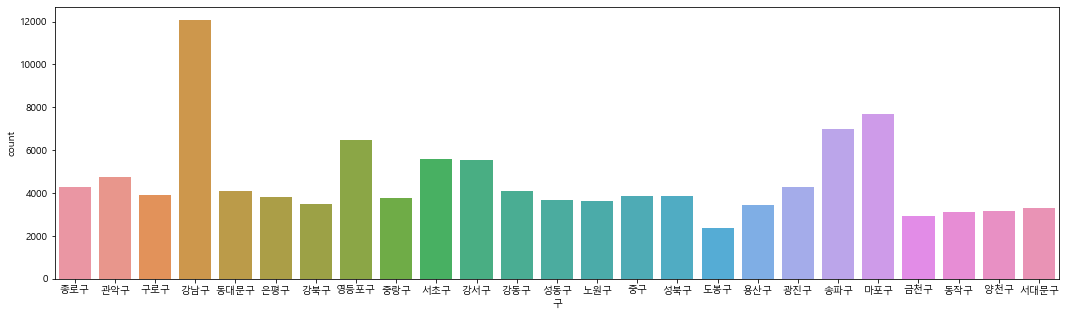

In [21]:
plt.figure(figsize=(18,5))
plt.rcParams['font.family'] = 'Malgun Gothic'
sns.countplot(df['구'])
plt.show()

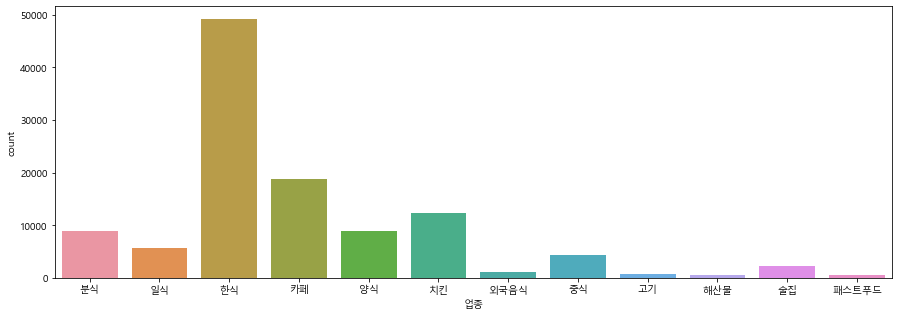

In [22]:
plt.figure(figsize=(15,5))
plt.rcParams['font.family'] = 'Malgun Gothic'
sns.countplot(df['업종'])
plt.show()

In [23]:
df = df.reset_index(drop=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114055 entries, 0 to 114054
Data columns (total 6 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   구        114055 non-null  object 
 1   동        114055 non-null  object 
 2   사업장명     114055 non-null  object 
 3   업종       114055 non-null  object 
 4   좌표정보(X)  114055 non-null  float64
 5   좌표정보(Y)  114055 non-null  float64
dtypes: float64(2), object(4)
memory usage: 5.2+ MB


In [24]:
df.head(10)

,구,동,사업장명,업종,좌표정보(X),좌표정보(Y)
0,종로구,관철동,상해,분식,198867.702591,451824.281126
1,관악구,신림동,미쿠,일식,193687.348199,442284.164025
2,구로구,구로동,여름엔빙수겨울엔떡국,한식,189814.305919,443046.239859
3,강남구,대치동,카페디퍼,카페,204776.548264,444677.642985
4,동대문구,신설동,메이크데이(MakeDay),카페,202114.228397,452392.093759
5,은평구,응암동,달의 작업실(Lalune),한식,192540.370555,454712.243026
6,강남구,논현동,숯칼 도산 숯닭갈비,한식,202545.473911,446358.225573
7,강북구,수유동,테트리스찜닭 수유미아점,한식,201836.387383,458885.456680
8,영등포구,일부)호,블러프라운지,카페,193717.614336,446460.363568
9,강남구,역삼동,탐라정성돈카츠(탐정돈),일식,204222.892947,444524.822712


### 자치구, 자치동, 음식종류 입력받아 음식점 리스트 반환

In [25]:
# print('자치구 목록:', end= ' ')
# for i in list(df['구'].unique()):
#     print(i, end=', ')
# print()
# print('원하시는 자치구를 입력해주세요:')
# gu = input()

# print('자치동 목록:', end=' ')
# for i in list(df[df['구'] == gu]['동'].unique()):
#     print(i, end=', ')
# print()
# print('원하시는 자치동을 입력해주세요:')
# dong = input()

# print('음식종류 목록: 상관없음', end=', ')
# for i in list(df['업종'].unique()):
#     print(i, end=', ')
# print()
# print('원하시는 음식종류를 입력해주세요:')
# food = input()

# if food == '상관없음':
#     food_list = df[df['구'] == gu][df['동'] == dong]['사업장명'].tolist()
# else:
#     food_list = df[df['구'] == gu][df['동'] == dong][df['업종'] == food]['사업장명'].tolist()

# keyword_list = [gu+' '+dong+' '+i for i in food_list]
#동작구 흑석동 상관없음

자치구 목록: 종로구, 관악구, 구로구, 강남구, 동대문구, 은평구, 강북구, 영등포구, 중랑구, 서초구, 강서구, 강동구, 성동구, 노원구, 중구, 성북구, 도봉구, 용산구, 광진구, 송파구, 마포구, 금천구, 동작구, 양천구, 서대문구, 
원하시는 자치구를 입력해주세요:
동작구
자치동 목록: 사당동, 상도1동, 신대방동, 흑석동, 상도동, 노량진동, 대방동, 
원하시는 자치동을 입력해주세요:
흑석동
음식종류 목록: 상관없음, 분식, 일식, 한식, 카페, 양식, 치킨, 외국음식, 중식, 고기, 해산물, 술집, 패스트푸드, 
원하시는 음식종류를 입력해주세요:
상관없음


### 전처리 데이터 저장

In [26]:
df.to_csv('./seoul_food.csv',encoding='cp949',index=False)